## Preparar el Entorno

In [1]:
# pip install --upgrade pycaret scipy

In [2]:
# Importación de librerías esenciales para manipulación y análisis de datos
import pandas as pd
import numpy as np

# Importación de librerías para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Herramientas de preprocesamiento de sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

# Modelos y herramientas de selección y evaluación de sklearn
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, explained_variance_score
from sklearn.pipeline import Pipeline

# Configuraciones específicas para mejorar la visualización en cuadernos Jupyter
pd.set_option('display.max_rows', 50)  # Limitar el máximo de filas visibles para mejorar la performance
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas disponibles

# Ajustes del sistema y manejo de módulos personalizados
import sys
sys.path.append('../src/utils')

# Importación de módulos personalizados para funcionalidades específicas
from utils import (
    load_data,
    plot_boxplot,
    plot_category_counts,
    plot_heatmap
)

from preprocess import *
from modeling_dev import *

# Importaciones específicas de PyCaret para facilitar el modelado y la clasificación
from pycaret.classification import *
from pycaret.utils import version
version()  # Muestra la versión de PyCaret para asegurar compatibilidad

'3.3.2'

## Cargar los Datos

In [3]:
df = load_data('../data/processed/dataset_complete.csv')
print("Dimensiones del DataFrame cargado:", df.shape)

Datos cargados con dimensiones iniciales: (717, 66)
Dimensiones del DataFrame cargado: (717, 66)


In [4]:
df.head()

edad  sexo  altura  peso  num calzado    articulacion     localizacion  \
0    36     0     173  65.0         40.0         rodilla           medial   
1    35     1     181  78.0         44.0  sin afectacion  no especificado   
2    45     1     189  88.0         46.0  sin afectacion  no especificado   
3    43     1     182  70.0         44.0             pie           medial   
4    41     1     184  90.0         43.0          pierna        posterior   

              lado  pace_walk  velocidad_walk  step rate_walk  \
0                b   1.291600             5.0      108.456898   
1  no especificado   1.370079             5.0      114.767847   
2  no especificado   1.371909             5.0      100.149777   
3                d   1.318286             5.0      103.976334   
4                b   1.362836             5.0       99.062660   

   stride length_walk  shock_walk  impact gs_walk  braking gs_walk  \
0              1.4267    3.566339        2.310324         2.610172   
1              1.4312    3.119538        1.900867         2.387259   
2              1.6437    2.368494        1.597828         1.558757   
3              1.5381    2.667928        1.708754         1.985392   
4              1.6541    3.610964        2.665554         2.369300   

   footstrike type_walk  pronation excursion_walk  contact ratio_walk  \
0              6.314815                -11.106498           63.724990   
1              6.948276                 -8.176466           62.112399   
2             10.680851                 -4.411249           64.721319   
3             11.180000                 -4.351264           63.545858   
4              7.900000                -10.180634           67.074954   

   total force rate_walk  step length_walk  pronation excursion (mp->to)_walk  \
0              24.952120            0.7133                         -14.725130   
1              30.589598            0.7156                           0.962024   
2              32.726926            0.8218                           0.192496   
3              28.220870            0.7690                           6.506884   
4              33.841236            0.8270                          -6.480006   

   stance excursion (fs->mp)_walk  stance excursion (mp->to)_walk  \
0                       19.445907                       62.315404   
1                       17.340533                       55.030184   
2                        8.006323                       77.799223   
3                        7.471882                       81.783758   
4                       14.944068                       89.849386   

   m1 hipermovil  thomas psoas  thomas rf  thomas tfl  ober  arco aplanado  \
0              0             0          0           0     0              0   
1              0             0          0           0     0              0   
2              0             0          0           0     0              0   
3              3             0          3           0     0              0   
4              0             0          3           1     0              0   

   arco elevado  m1 dfx  m5 hipermovil  arco transverso disminuido  m1 pfx  \
0             3       0              0                           0       0   
1             0       0              0                           0       0   
2             0       0              0                           0       0   
3             0       3              0                           0       0   
4             3       0              0                           0       3   

   arco transverso aumentado  hlf  hl  hr  hav  index minus  tfi  tfe  tti  \
0                          0    0   0   0    3            3    0    3    0   
1                          0    0   0   0    0            0    0    0    0   
2                          0    0   0   0    0            0    0    0    0   
3                          0    0   0   0    0            3    0    0    0   
4                          3    0   0   0    0            3

In [5]:
print(f"Nº de categorías únicas en 'articulacion' antes de la transformación: {df['articulacion'].nunique()}")

Nº de categorías únicas en 'articulacion' antes de la transformación: 8


In [6]:
# Agrupación de categorías menos frecuentes en una nueva categoría llamada 'otro'
df['articulacion'] = df['articulacion'].replace(['pierna', 'cadera', 'espalda', 'sin afectacion', 'muslo', 'complejo'], 'otro')
print(f"Número de categorías únicas en 'articulacion' después de la transformación: {df['articulacion'].nunique()}")

Número de categorías únicas en 'articulacion' después de la transformación: 4


In [7]:
# Eliminación de columnas que no se utilizarán
df = df.drop(columns=['localizacion', 'lado', 'zona afectada'])

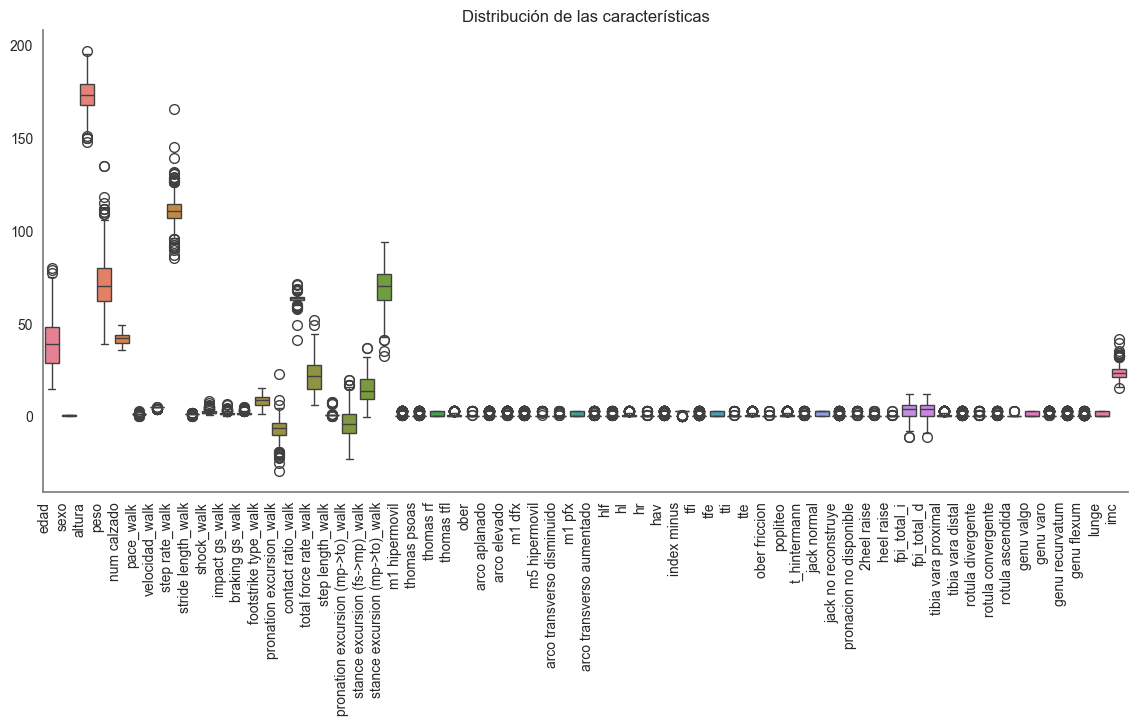

In [8]:
plot_boxplot(df) # Visualización

## División en train y test

In [9]:
# Preparación de los datos
X = df.drop('articulacion', axis=1)  # Eliminar la columna objetivo del conjunto de características
y = df['articulacion']               # Definir el conjunto objetivo

# División del conjunto de datos en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Visualización de las dimensiones de los conjuntos de datos
print(f'Dimensiones del dataset de train: {X_train.shape} | {y_train.shape}')
print(f'Dimensiones del dataset de validación: {X_test.shape} | {y_test.shape}')

X_train.head()

Dimensiones del dataset de train: (573, 62) | (573,)
Dimensiones del dataset de validación: (144, 62) | (144,)


edad  sexo  altura  peso  num calzado  pace_walk  velocidad_walk  \
75     45     1     178  80.0         44.1   1.431927             5.0   
256    43     1     170  71.0         42.0   1.316527             5.0   
626    30     1     178  74.0         41.0   1.383853             5.0   
8      50     0     165  67.0         37.0   0.083356             5.0   
149    47     0     170  60.0         40.0   1.381579             5.0   

     step rate_walk  stride length_walk  shock_walk  impact gs_walk  \
75       112.891509              1.5229    2.326613        2.014790   
256      113.289981              1.4059    1.859483        0.987038   
626      108.546666              1.5321    1.973759        1.317979   
8        124.494250              0.0803    2.660461        1.821702   
149      112.642498              1.4708    2.907667        2.121389   

     braking gs_walk  footstrike type_walk  pronation excursion_walk  \
75          1.131385             12.089286                 -1.934450   
256         1.464532             11.022472                 -3.463675   
626         1.445499              9.339623                 -9.473472   
8           1.860127             11.419355                 -6.135594   
149         1.946341             12.375000                 -4.351580   

     contact ratio_walk  total force rate_walk  step length_walk  \
75            63.539849              29.526575            0.7614   
256           64.150504              28.362304            0.7030   
626           64.472397              16.185594            0.7661   
8             66.482163              16.611606            0.0401   
149           62.359526              28.840264            0.7354   

     pronation excursion (mp->to)_walk  stance excursion (fs->mp)_walk  \
75                          -12.226850                        5.191136   
256                          -8.461037                        7.424516   
626                          -2.814574                       11.068998   
8                            -1.784790                        6.559235   
149                          -7.837623                        4.836789   

     stance excursion (mp->to)_walk  m1 hipermovil  thomas psoas  thomas rf  \
75                        80.358554              0             0          3   
256                       74.429788              0             2          3   
626                       79.124419              0             0          3   
8                         61.928437              0             0          0   
149                       79.862173              2             0          0   

     thomas tfl  ober  arco aplanado  arco elevado  m1 dfx  m5 hipermovil  \
75            3     0              3             0       0              0   
256           1     0              0             0       0              0   
626           0     0              0             3       0              0   
8             1     0              3             0       0              0   
149           0     0              1             0       0              0   

     arco transverso disminuido  m1 pfx  arco transverso aumentado  hlf  hl  \
75                            0       0                          0    0   0   
256                           0       3                          0    0   0   
626                           0       0                          0    0   0   
8                             0       0                          0    0   0   
149                           0       0                          0    0   0   

     hr  hav  index minus  tfi  tfe  tti  tte  ober friccion  popliteo  \
75    0    0            3    0    3    0    0              0         3   
256   0    0            3    0    3    0    0              1         3   
626   0    0            3    0    3    0    3              0         3   
8     0    3            3    0    0    0    3              0         0   
149   0    3            3    0    0    0    0              0         

In [10]:
# Guardamos
# X_train.to_csv('../data/processed/sin_escalar/X_train.csv', sep=';', decimal='.', index=False)
# X_test.to_csv('../data/processed/sin_escalar/X_test.csv', sep=';', decimal='.', index=False)
# y_train.to_csv('../data/processed/sin_escalar/y_train.csv', sep=';', decimal='.', index=False)
# y_test.to_csv('../data/processed/sin_escalar/y_test.csv', sep=';', decimal='.', index=False)

In [11]:
# Cargar los dataset
# X_train = pd.read_csv('../data/processed/sin_escalar/X_train.csv', sep=';', decimal='.')
# X_test = pd.read_csv('../data/processed/sin_escalar/X_test.csv', sep=';', decimal='.')
# y_train = pd.read_csv('../data/processed/sin_escalar/y_train.csv', sep=';', decimal='.')
# y_test = pd.read_csv('../data/processed/sin_escalar/y_test.csv', sep=';', decimal='.')

X_train.head()

edad  sexo  altura  peso  num calzado  pace_walk  velocidad_walk  \
75     45     1     178  80.0         44.1   1.431927             5.0   
256    43     1     170  71.0         42.0   1.316527             5.0   
626    30     1     178  74.0         41.0   1.383853             5.0   
8      50     0     165  67.0         37.0   0.083356             5.0   
149    47     0     170  60.0         40.0   1.381579             5.0   

     step rate_walk  stride length_walk  shock_walk  impact gs_walk  \
75       112.891509              1.5229    2.326613        2.014790   
256      113.289981              1.4059    1.859483        0.987038   
626      108.546666              1.5321    1.973759        1.317979   
8        124.494250              0.0803    2.660461        1.821702   
149      112.642498              1.4708    2.907667        2.121389   

     braking gs_walk  footstrike type_walk  pronation excursion_walk  \
75          1.131385             12.089286                 -1.934450   
256         1.464532             11.022472                 -3.463675   
626         1.445499              9.339623                 -9.473472   
8           1.860127             11.419355                 -6.135594   
149         1.946341             12.375000                 -4.351580   

     contact ratio_walk  total force rate_walk  step length_walk  \
75            63.539849              29.526575            0.7614   
256           64.150504              28.362304            0.7030   
626           64.472397              16.185594            0.7661   
8             66.482163              16.611606            0.0401   
149           62.359526              28.840264            0.7354   

     pronation excursion (mp->to)_walk  stance excursion (fs->mp)_walk  \
75                          -12.226850                        5.191136   
256                          -8.461037                        7.424516   
626                          -2.814574                       11.068998   
8                            -1.784790                        6.559235   
149                          -7.837623                        4.836789   

     stance excursion (mp->to)_walk  m1 hipermovil  thomas psoas  thomas rf  \
75                        80.358554              0             0          3   
256                       74.429788              0             2          3   
626                       79.124419              0             0          3   
8                         61.928437              0             0          0   
149                       79.862173              2             0          0   

     thomas tfl  ober  arco aplanado  arco elevado  m1 dfx  m5 hipermovil  \
75            3     0              3             0       0              0   
256           1     0              0             0       0              0   
626           0     0              0             3       0              0   
8             1     0              3             0       0              0   
149           0     0              1             0       0              0   

     arco transverso disminuido  m1 pfx  arco transverso aumentado  hlf  hl  \
75                            0       0                          0    0   0   
256                           0       3                          0    0   0   
626                           0       0                          0    0   0   
8                             0       0                          0    0   0   
149                           0       0                          0    0   0   

     hr  hav  index minus  tfi  tfe  tti  tte  ober friccion  popliteo  \
75    0    0            3    0    3    0    0              0         3   
256   0    0            3    0    3    0    0              1         3   
626   0    0            3    0    3    0    3              0         3   
8     0    3            3    0    0    0    3              0         0   
149   0    3            3    0    0    0    0              0         

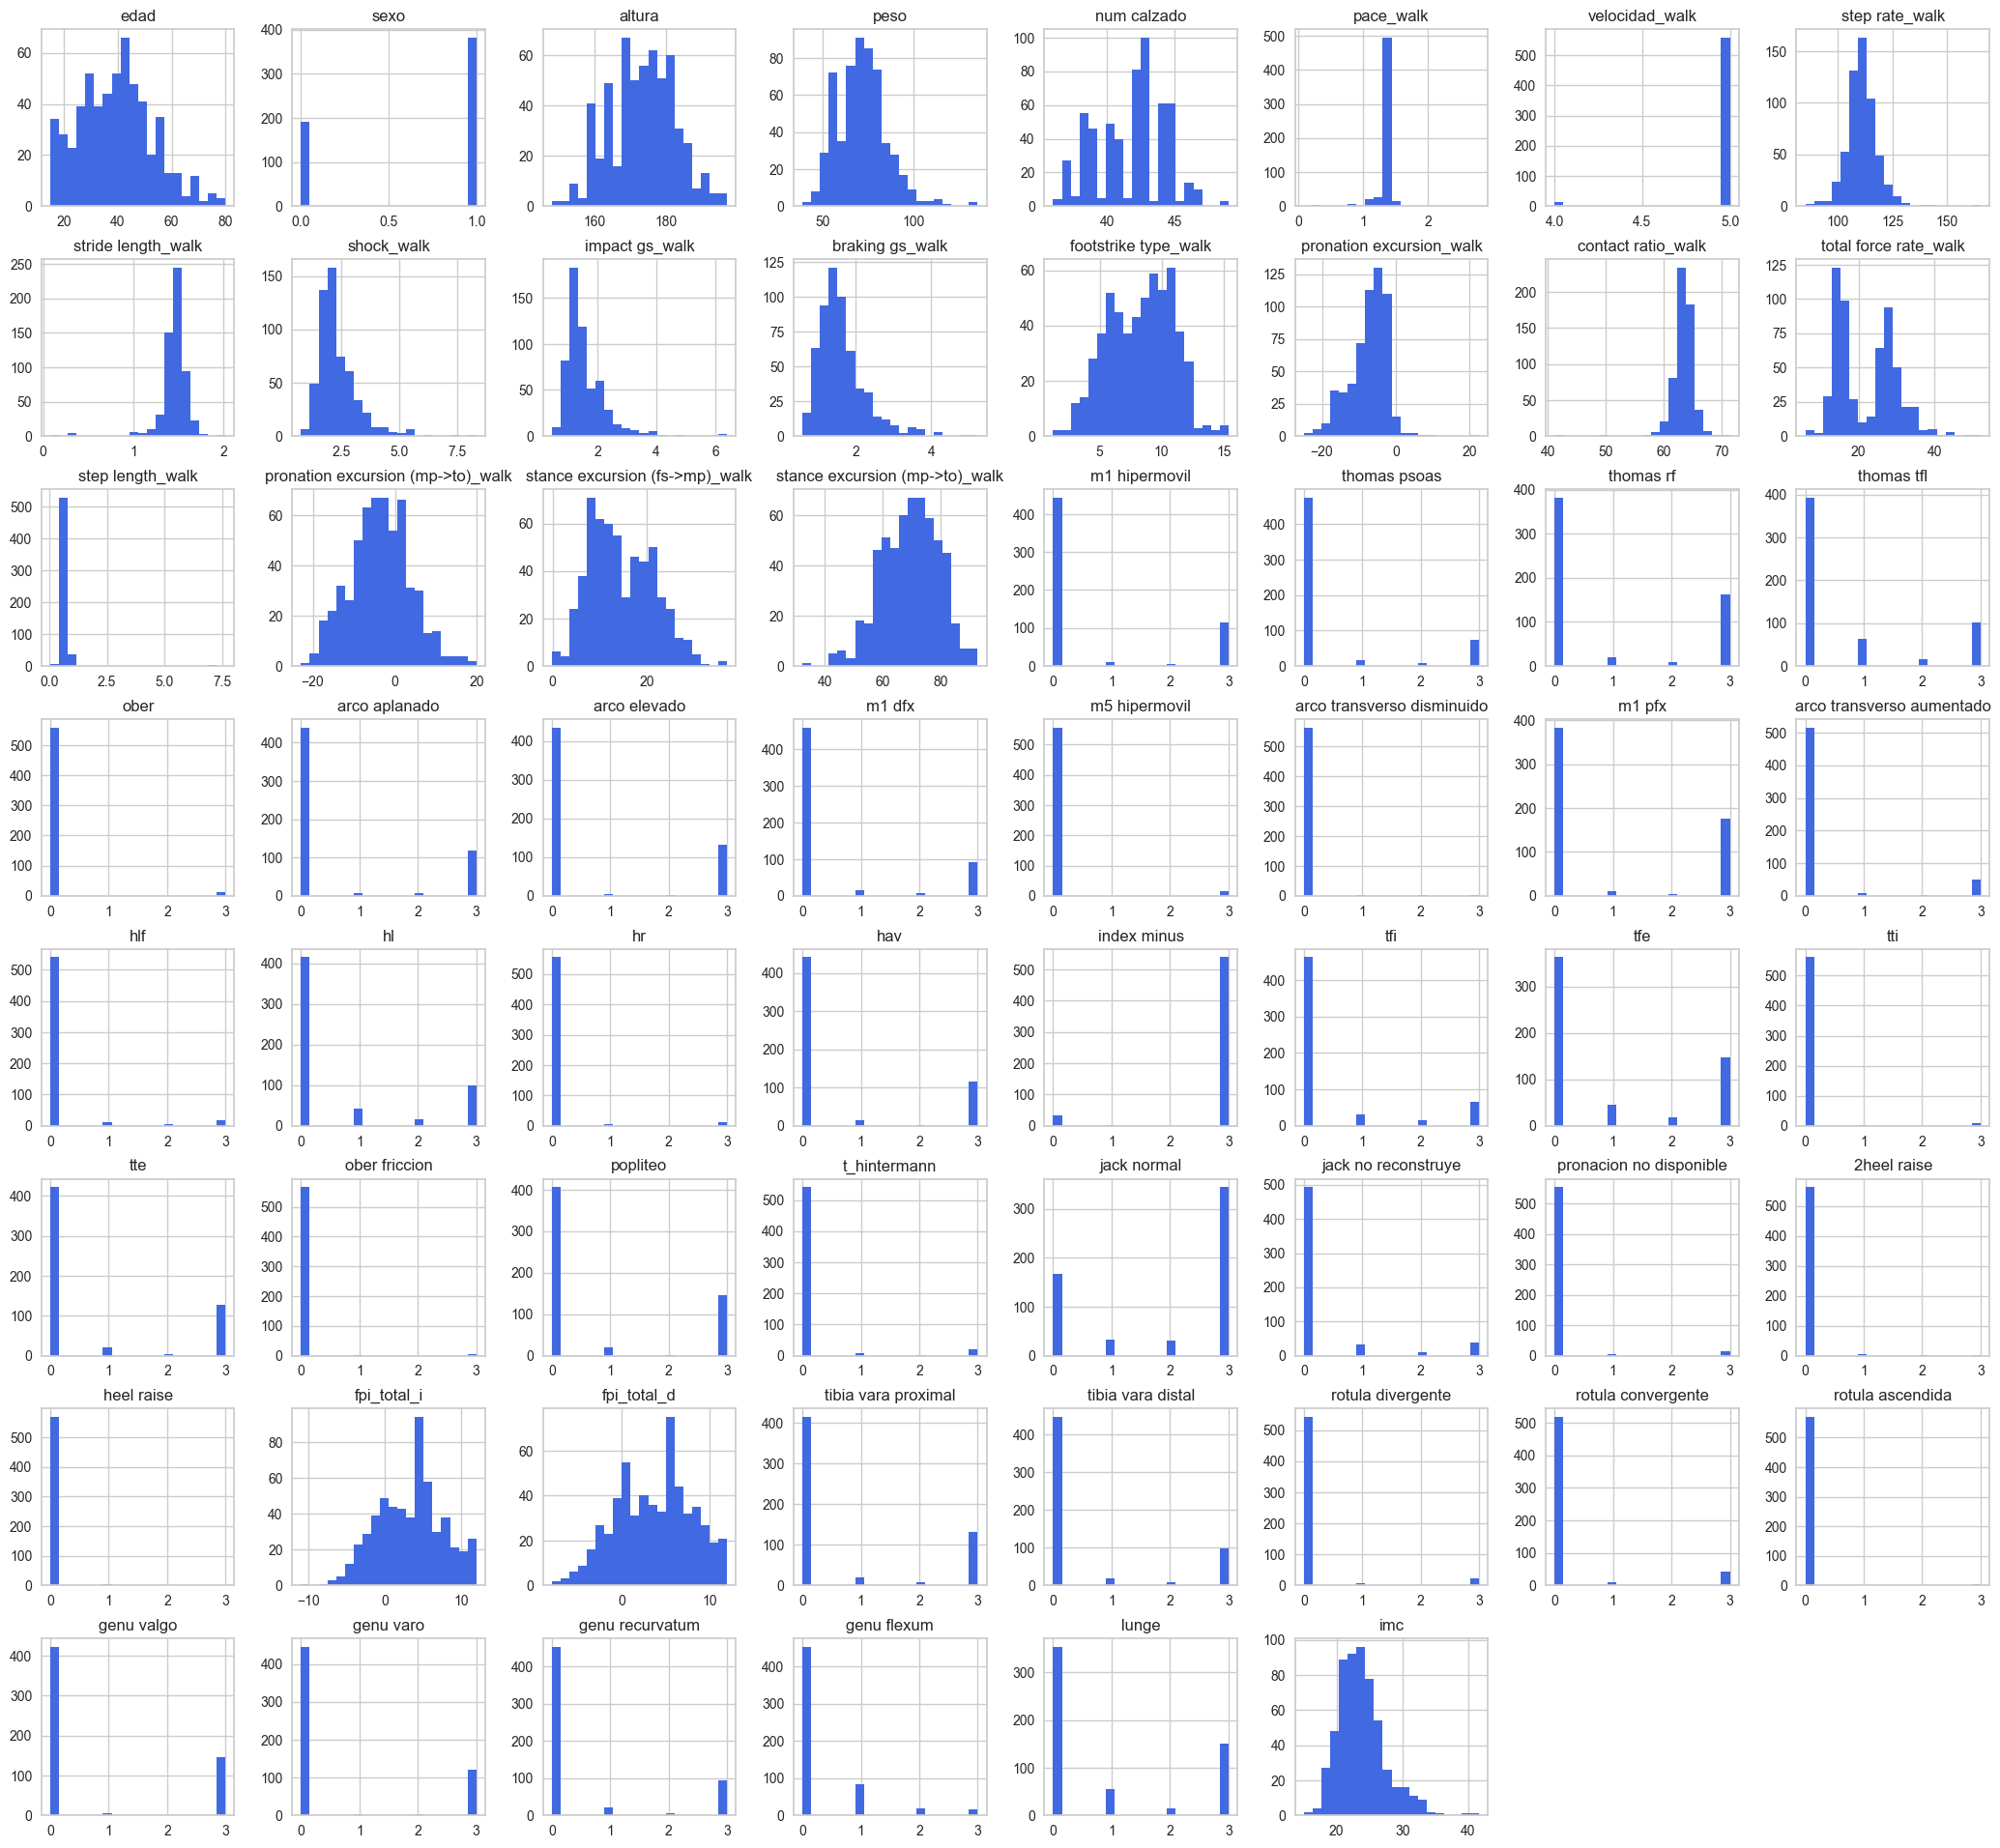

In [12]:
# Histograma del conjunto de entrenamiento
X_train.hist(bins=20, figsize=(26, 24), color='royalblue')
plt.show()

In [13]:
# Estadísticas descriptivas del conjunto de entrenamiento
display(X_train.describe().round(3))

edad     sexo   altura     peso  num calzado  pace_walk  \
count  573.000  573.000  573.000  573.000      573.000    573.000   
mean    39.215    0.667  173.328   71.631       41.719      1.347   
std     13.544    0.472    8.911   13.583        2.625      0.154   
min     15.000    0.000  148.000   39.000       36.000      0.083   
25%     29.000    0.000  168.000   62.000       40.000      1.361   
50%     39.000    1.000  173.000   71.000       42.000      1.371   
75%     48.000    1.000  180.000   80.000       44.000      1.379   
max     80.000    1.000  197.000  135.000       49.000      2.794   

       velocidad_walk  step rate_walk  stride length_walk  shock_walk  \
count         573.000         573.000             573.000     573.000   
mean            4.975         111.153               1.456       2.315   
std             0.155           7.158               0.160       0.875   
min             4.000          85.079               0.080       0.750   
25%             5.000         106.987               1.412       1.746   
50%             5.000         110.876               1.477       2.083   
75%             5.000         114.822               1.531       2.655   
max             5.000         165.523               2.025       8.329   

       impact gs_walk  braking gs_walk  footstrike type_walk  \
count         573.000          573.000               573.000   
mean            1.546            1.631                 8.301   
std             0.671            0.638                 2.613   
min             0.445            0.587                 1.250   
25%             1.132            1.209                 6.173   
50%             1.364            1.496                 8.640   
75%             1.786            1.866                10.358   
max             6.403            5.236                15.404   

       pronation excursion_walk  contact ratio_walk  total force rate_walk  \
count                   573.000             573.000                573.000   
mean                     -7.295              63.490                 21.937   
std                       5.026               1.925                  7.771   
min                     -24.901              41.133                  5.952   
25%                      -9.849              62.619                 14.845   
50%                      -6.237              63.627                 19.978   
75%                      -3.663              64.425                 27.978   
max                      22.671              71.494                 52.165   

       step length_walk  pronation excursion (mp->to)_walk  \
count           573.000                            573.000   
mean              0.773                             -3.521   
std               0.542                              7.341   
min               0.040                            -22.855   
25%               0.706                             -8.441   
50%               0.739                             -3.532   
75%               0.767                              1.047   
max               7.664                             19.832   

       stance excursion (fs->mp)_walk  stance excursion (mp->to)_walk  \
count                         573.000                         573.000   
mean                           14.615                          69.521   
std                             6.712                           9.805   
min                            -0.159                          32.312   
25%                             9.161                          62.430   
50%                            13.729                          70.310   
75%                            19.983                          76.695   
max                            37.078                          92.868   

       m1 hipermovil  thomas psoas  thomas rf  thomas tfl     ober  \
count        573.000       573.000    573.000     573.000  573.000   
mean           0.635         0.442      0.916       0.696    0.070   
std            1.207   

In [14]:
# Cálculo de percentiles críticos para características específicas
percentil_98_pace = df['pace_walk'].quantile(0.98)
percentil_98_stride_length = df['stride length_walk'].quantile(0.98)

# Filtrado de registros que superen el percentil 98 en características específicas
high_pace_walk = df[df['pace_walk'] > percentil_98_pace]
high_stride_length_walk = df[df['stride length_walk'] > percentil_98_stride_length]

# Visualización de los resultados filtrados
print("Registros con pace_walk alto:")
print(high_pace_walk[['pace_walk', 'stride length_walk']])
print("\nRegistros con stride length_walk alto:")
print(high_stride_length_walk[['pace_walk', 'stride length_walk']])

Registros con pace_walk alto:
     pace_walk  stride length_walk
24    1.466770            1.697700
108   1.460815            1.694800
127   1.495747            1.471800
128   1.495747            1.471800
135   1.492680            1.574900
248   1.482486            1.357700
281   1.467390            1.629000
394   1.477679            1.566000
403   1.455382            1.608100
424   1.486504            1.610200
554   2.325577            1.941543
571   1.907261            1.727432
572   1.907261            1.727432
574   2.793561            2.024550
676   1.454388            1.672300

Registros con stride length_walk alto:
     pace_walk  stride length_walk
24    1.466770            1.697700
108   1.460815            1.694800
220   1.368494            1.717100
239   1.404306            1.688000
240   1.404306            1.688000
241   1.404306            1.688000
343   1.373040            1.811300
344   1.373040            1.811300
552   1.349389            1.764691
554   2.325577      

Optamos por conservar los registros debido a que parecen legítimos y representativos de un subgrupo específico.

## Codificar Variable Objetivo

In [15]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

## Escalado de Datos

Para los modelos **Random Forest y Decision Tree**, que no son sensibles al escalado de las características, ya que realizan divisiones basadas en el orden y no en la magnitud, no escalaremos los datos.

## Selección de Características

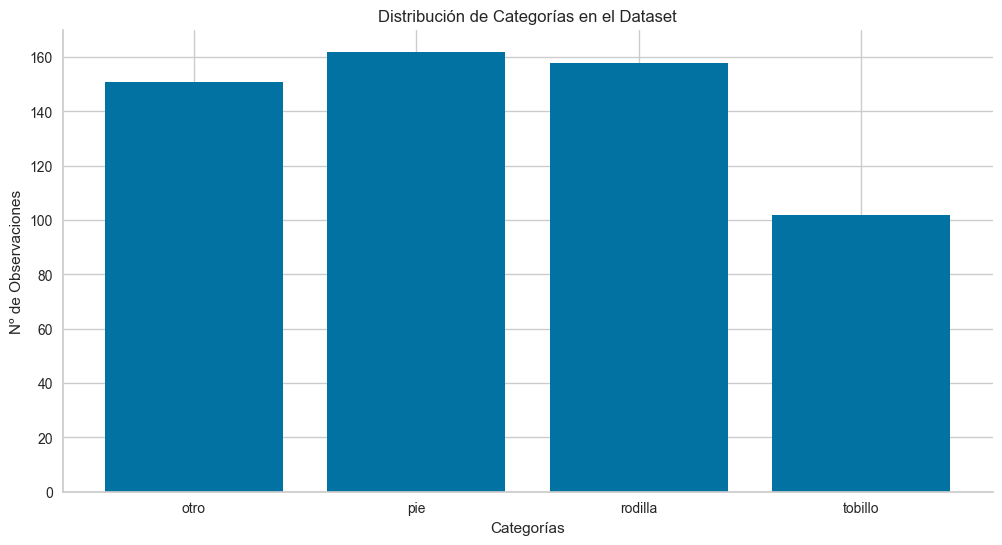

In [16]:
plot_category_counts(y_train, 'Distribución de Categorías en el Dataset')

In [17]:
# Eliminar características constantes
X_train_var = X_train.loc[:, X_train.var() != 0] # En X_train es la columna 'pnca ap valgo'

# Suponiendo que X_train es tu conjunto de entrenamiento y y_train son las etiquetas
selector = SelectKBest(score_func=f_classif, k='all')  # 'all' para seleccionar todas las características y ver sus puntuaciones
selector.fit(X_train_var, y_train)

# Muestra las puntuaciones de ANOVA para cada característica
print("Puntuaciones F de ANOVA:", selector.scores_)

Puntuaciones F de ANOVA: [1.06646085 4.81089112 2.94041921 1.82980159 2.82588555 0.86354468
 0.04679907 1.44185914 1.717855   3.10212622 3.28431398 2.21912517
 0.21422796 1.65781819 1.59975547 8.1668386  0.47655017 0.28126439
 0.09928221 1.70063061 0.26507218 4.39322399 1.94683702 4.76807426
 1.57051599 0.72608804 0.7131213  2.30370136 0.46115443 2.55732254
 0.54754538 0.12844644 1.74342114 1.18480545 1.35850443 2.46706741
 5.8887358  1.28743635 1.00568414 1.38860961 0.51157749 1.56433242
 0.41815726 0.77808872 2.14462007 2.96618735 2.34866709 0.51719317
 0.54210066 0.86955965 0.45150191 2.27720956 0.7994806  1.46988581
 0.71711985 0.04800951 0.87754986 0.11467424 1.58977147 0.17002249
 0.1300058  1.3980537 ]


Las características con las **puntuaciones F más altas son más relevantes para predecir la variable objetivo**. Por ejemplo, los valores mayores (como `8.20979186` para `total force rate_walk`) indican una mayor relevancia.

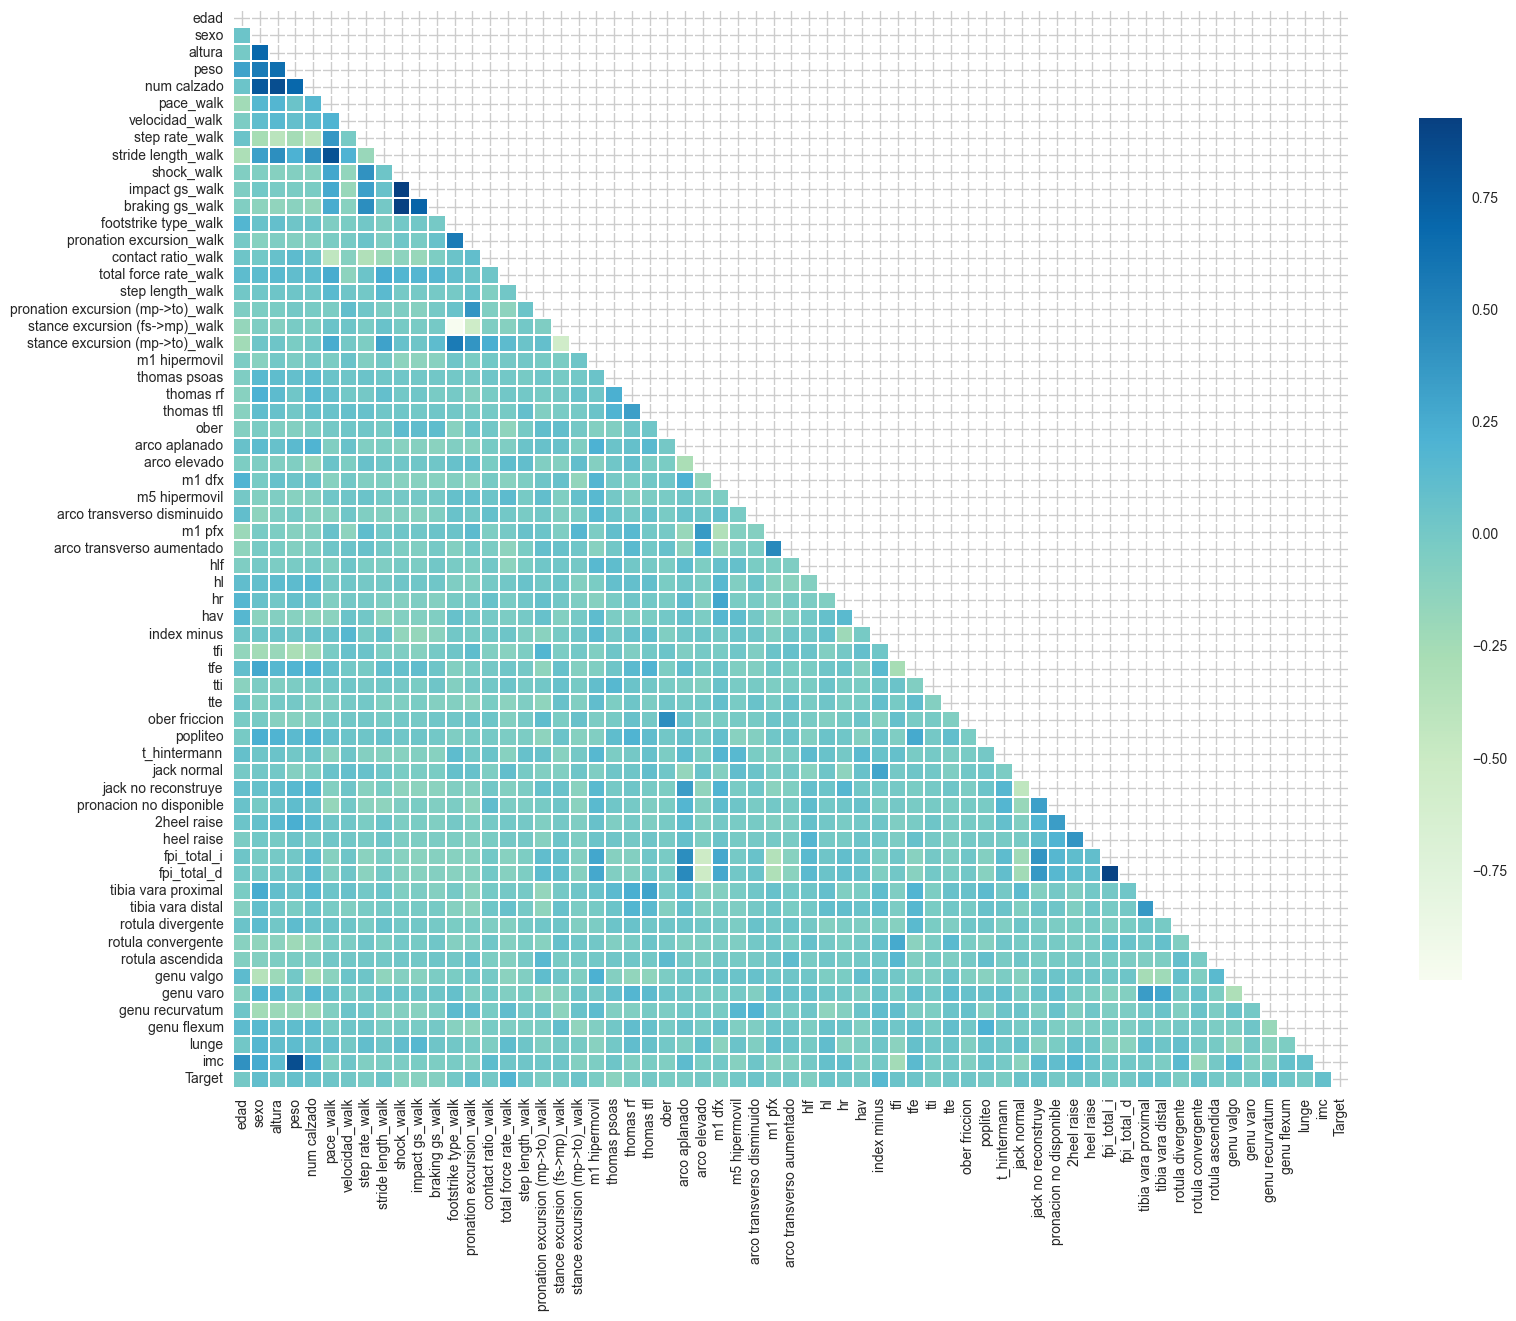

In [18]:
X_train_with_target = X_train.copy()
X_train_with_target['Target'] = y_train_encoded
corr_matrix = X_train_with_target.corr()
plot_heatmap(corr_matrix, figsize=(18, 14), cmap="GnBu", title='', annot=False)

In [19]:
threshold = 0.5 # Umbral de correlación

# Encuentra pares con una correlación superior al umbral
strong_pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
strong_pairs = strong_pairs.stack().reset_index()
strong_pairs.columns = ['variable1', 'variable2', 'correlation']

strong_pairs = strong_pairs[strong_pairs['correlation'] > threshold]  # Filtrar pares con correlación fuerte
strong_pairs = strong_pairs.sort_values('correlation', ascending=False) # Ordenar por correlación
strong_pairs

variable1                       variable2  correlation
522             shock_walk                  impact gs_walk     0.927667
523             shock_walk                 braking gs_walk     0.918198
1862           fpi_total_i                     fpi_total_d     0.902056
124                 altura                     num calzado     0.843144
240                   peso                             imc     0.839313
302              pace_walk              stride length_walk     0.819646
64                    sexo                     num calzado     0.771023
575         impact gs_walk                 braking gs_walk     0.708804
183                   peso                     num calzado     0.683861
62                    sexo                          altura     0.682605
123                 altura                            peso     0.636667
63                    sexo                            peso     0.558533
684   footstrike type_walk  stance excursion (mp->to)_walk     0.555707
678   footstrike type_walk        pronation excursion_walk     0.555232

Las **altas correlaciones** entre características (como `shock_walk` y `impact gs_walk`) sugieren **redundancia**.  Podemos considerar eliminar una de las características correlacionadas para reducir la multicolinealidad.

## PyCaret

In [20]:
# Configuración de PyCaret
clf1 = setup(data=df, 
             target='articulacion', 
             session_id=123, 
             log_experiment=True, 
             experiment_name='clasificacion_articulacion',
             preprocess=True,  # Preprocesamiento automático
             train_size=0.8)  # Cómo dividir el conjunto de datos en PyCaret

# Comparar modelos automáticamente
best_model = compare_models()
best_model

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [21]:
rf = create_model('rf', fold=10)

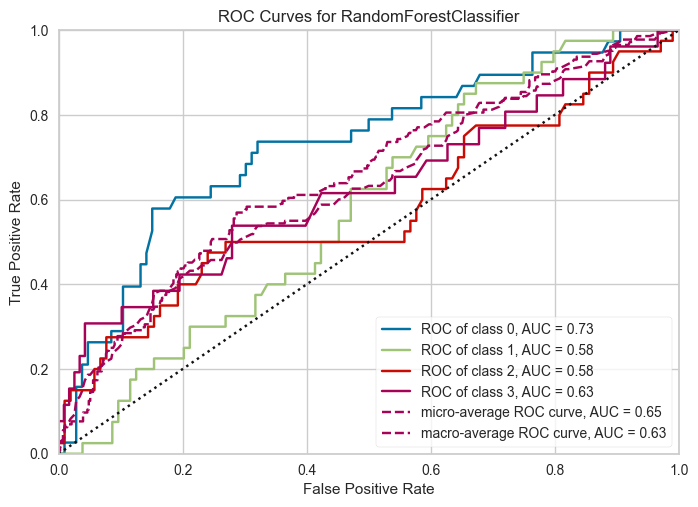

In [22]:
plot_model(rf)

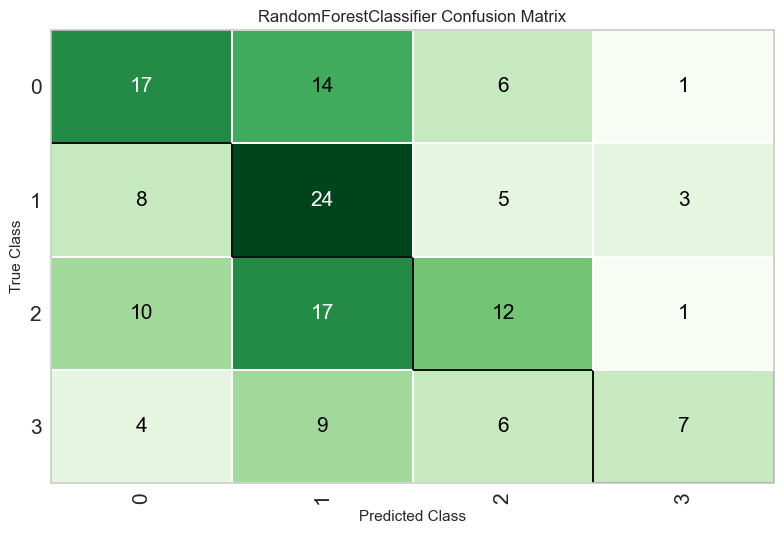

In [23]:
plot_model(rf, plot= 'confusion_matrix')

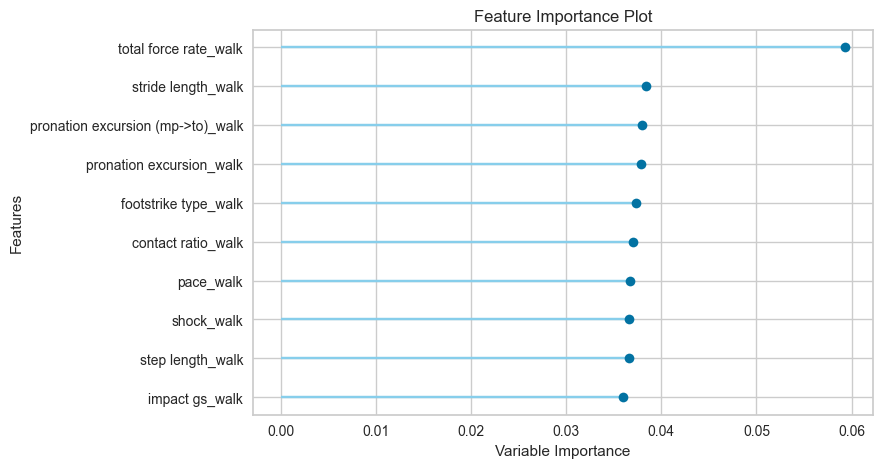

In [24]:
plot_model(rf, plot= 'feature')

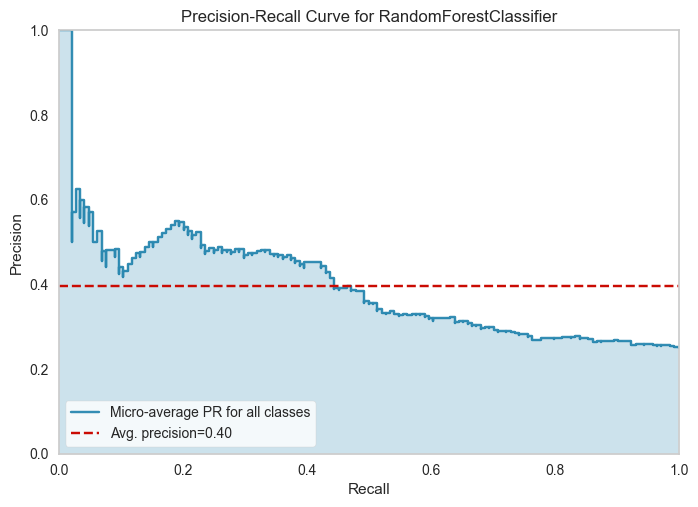

In [25]:
plot_model(rf, plot= 'pr')

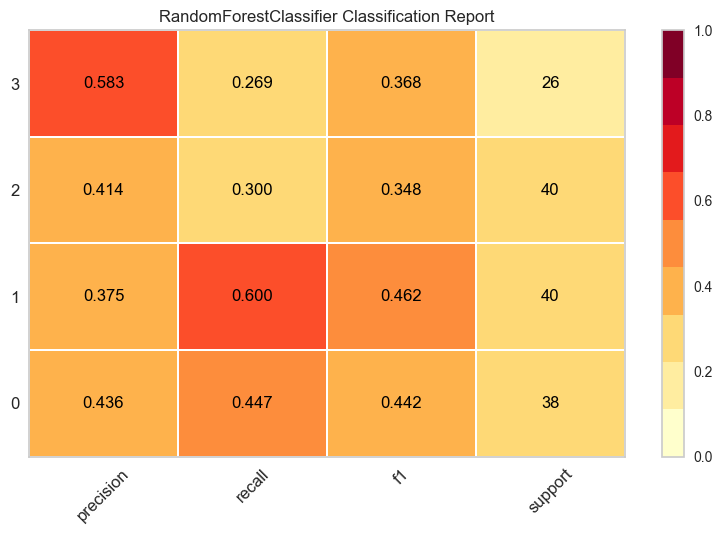

In [26]:
plot_model(rf, plot='class_report')

In [27]:
et = create_model('et', fold=10)

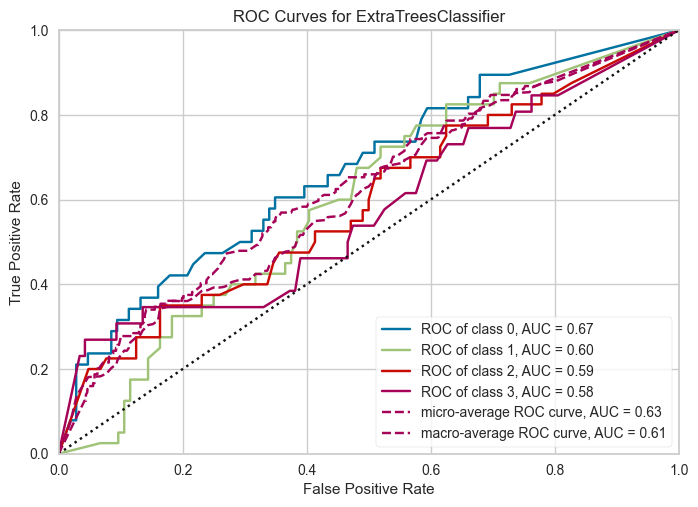

In [28]:
plot_model(et)

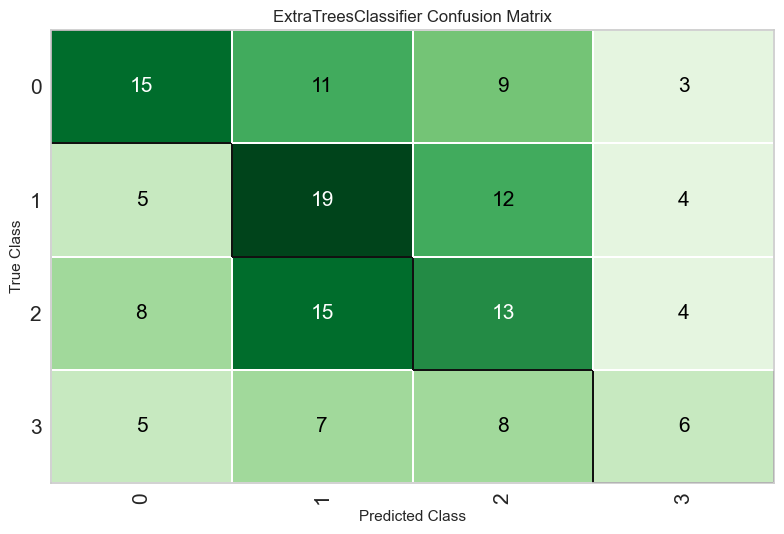

In [29]:
plot_model(et, plot= 'confusion_matrix')

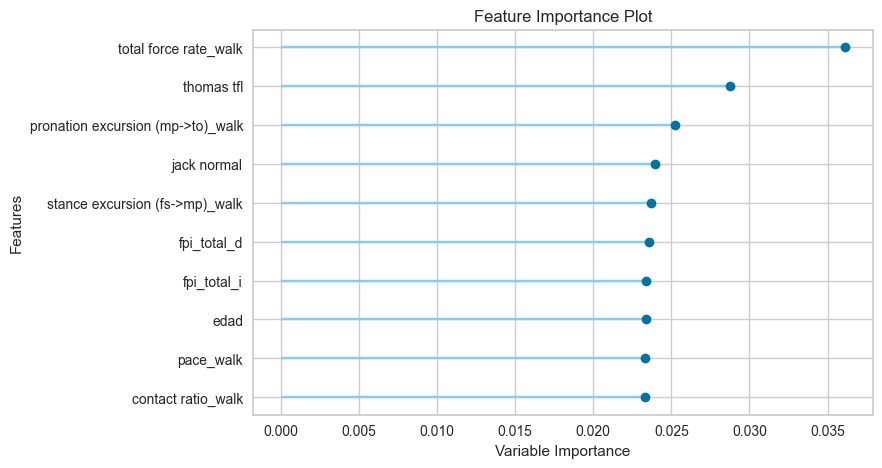

In [30]:
plot_model(et, plot= 'feature')

## Selección de Características

In [31]:
df.columns

Index(['edad', 'sexo', 'altura', 'peso', 'num calzado', 'articulacion',
       'pace_walk', 'velocidad_walk', 'step rate_walk', 'stride length_walk',
       'shock_walk', 'impact gs_walk', 'braking gs_walk',
       'footstrike type_walk', 'pronation excursion_walk',
       'contact ratio_walk', 'total force rate_walk', 'step length_walk',
       'pronation excursion (mp->to)_walk', 'stance excursion (fs->mp)_walk',
       'stance excursion (mp->to)_walk', 'm1 hipermovil', 'thomas psoas',
       'thomas rf', 'thomas tfl', 'ober', 'arco aplanado', 'arco elevado',
       'm1 dfx', 'm5 hipermovil', 'arco transverso disminuido', 'm1 pfx',
       'arco transverso aumentado', 'hlf', 'hl', 'hr', 'hav', 'index minus',
       'tfi', 'tfe', 'tti', 'tte', 'ober friccion', 'popliteo', 't_hintermann',
       'jack normal', 'jack no reconstruye', 'pronacion no disponible',
       '2heel raise', 'heel raise', 'fpi_total_i', 'fpi_total_d',
       'tibia vara proximal', 'tibia vara distal', 'rotula dive

In [32]:
columns = ['edad', 'sexo', 'altura', 'peso', 'num calzado', 'articulacion',
       'pace_walk', 'velocidad_walk', 'step rate_walk', 'stride length_walk', 'impact gs_walk', 'braking gs_walk',
       'pronation excursion_walk', 'contact ratio_walk', 'total force rate_walk', 'step length_walk',
       'pronation excursion (mp->to)_walk', 'stance excursion (fs->mp)_walk',
       'stance excursion (mp->to)_walk', 'm1 hipermovil', 'thomas psoas',
       'thomas tfl', 'arco aplanado', 'arco elevado', 'arco transverso disminuido', 'index minus',
       'tfi', 'tfe', 'tti', 'tte', 'popliteo', 't_hintermann',
       'jack normal', 'jack no reconstruye', '2heel raise', 'fpi_total_d',
       'tibia vara proximal', 'rotula convergente', 'rotula ascendida', 'genu valgo', 'genu varo', 'lunge', 'imc']

# Configuración de PyCaret
clf1 = setup(data=df[columns], 
             target='articulacion', 
             session_id=123, 
             log_experiment=True, 
             experiment_name='clasificacion_articulacion',
             preprocess=True,  # Preprocesamiento automático
             train_size=0.8)  # Cómo dividir el conjunto de datos en PyCaret

# Comparar modelos automáticamente
best_model = compare_models()
best_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

In [33]:
columns = ['edad', 'sexo', 'imc', 'articulacion', 'pace_walk', 'stride length_walk', 'impact gs_walk', 
       'total force rate_walk', 'pronation excursion (mp->to)_walk', 'stance excursion (fs->mp)_walk']

# Configuración de PyCaret
clf1 = setup(data=df[columns], 
             target='articulacion', 
             session_id=123, 
             log_experiment=True, 
             experiment_name='clasificacion_articulacion',
             preprocess=True,  # Preprocesamiento automático
             train_size=0.8)  # Cómo dividir el conjunto de datos en PyCaret

# Comparar modelos automáticamente
best_model = compare_models()
best_model

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)

In [34]:
et = create_model('et', fold=10)

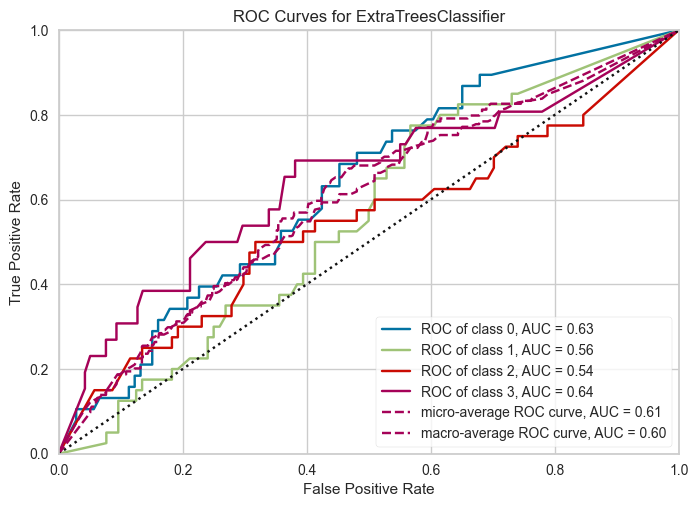

In [35]:
plot_model(et)

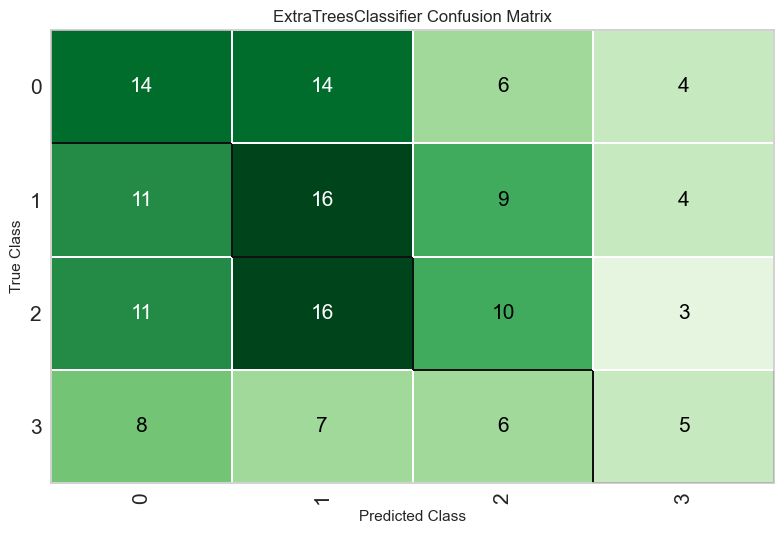

In [36]:
plot_model(et, plot= 'confusion_matrix')

## Árbol de Decisión

### Modelo 1

Train Accuracy: 0.4887
Test Accuracy: 0.4306
Best Parameters: {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}


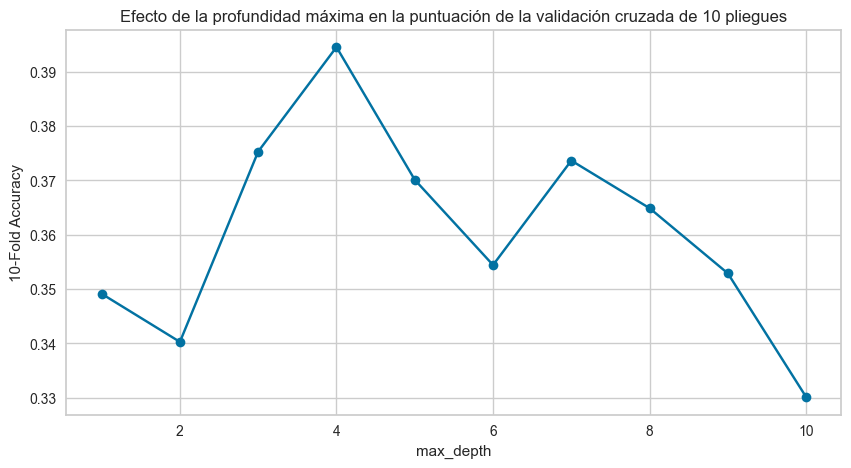

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, random_state=0, splitter='best')

In [37]:
params = {'max_depth': range(1, 11), 'min_samples_split': range(2, 10), 'min_samples_leaf': range(1, 5)}

best_model = train_evaluate_tree_model(X_train, y_train, X_test, y_test, params, cv_folds=10)
best_model

Predicciones realizadas con éxito
Conversión a numpy arrays exitosa
Cálculo de métricas exitoso
Resultados para DecisionTreeClassifier:
Accuracy: 0.4306
Precision: 0.3768
Recall: 0.4005
F1 Score: 0.3779


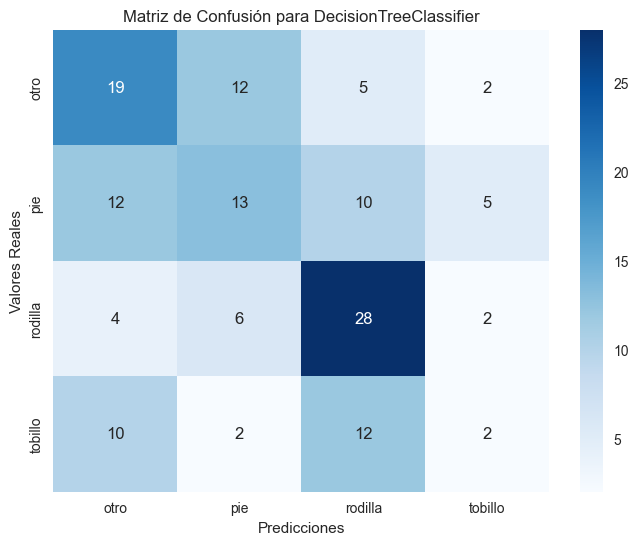

Visualización de la matriz de confusión exitosa


In [39]:
evaluate_model(best_model, X_test, y_test)

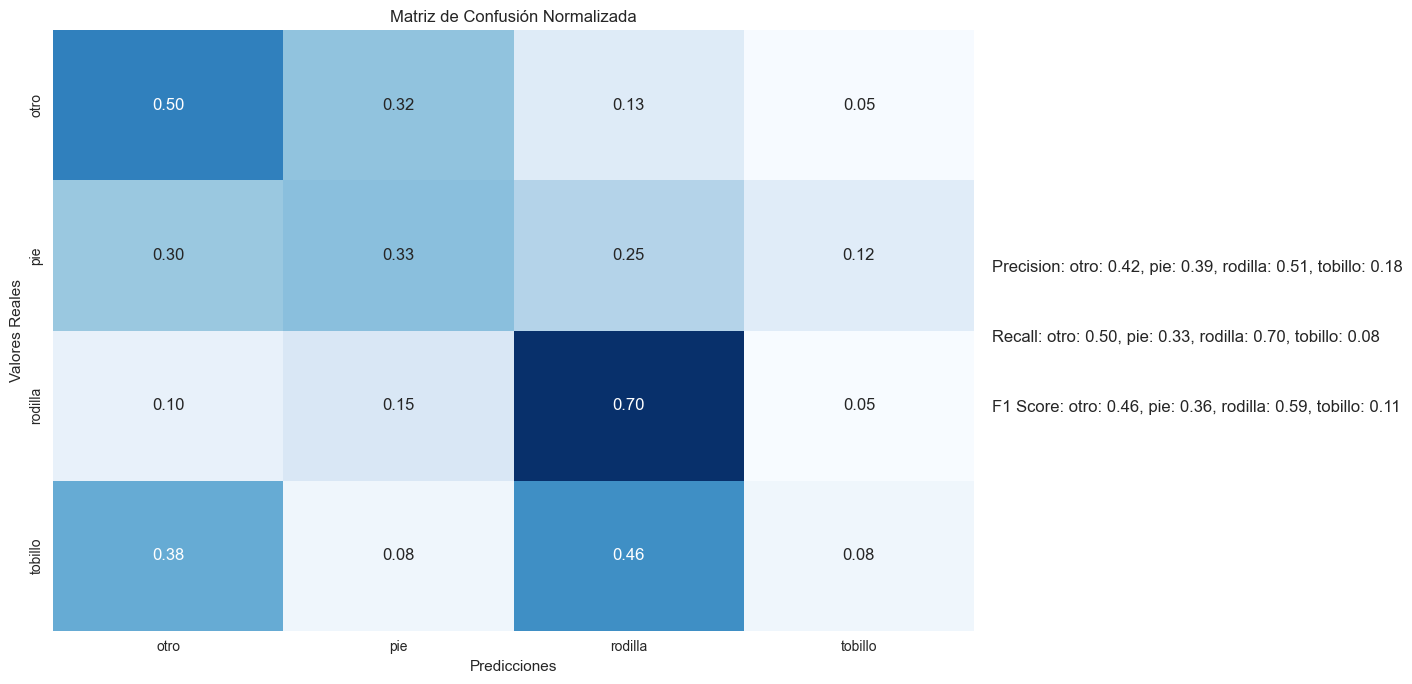


Classification Report:

              precision    recall  f1-score   support

        otro       0.42      0.50      0.46        38
         pie       0.39      0.33      0.36        40
     rodilla       0.51      0.70      0.59        40
     tobillo       0.18      0.08      0.11        26

    accuracy                           0.43       144
   macro avg       0.38      0.40      0.38       144
weighted avg       0.40      0.43      0.40       144



In [40]:
y_pred = best_model.predict(X_test)  # Etiquetas predichas por el modelo

plot_confusion_matrix_with_metrics(y_test, y_pred)

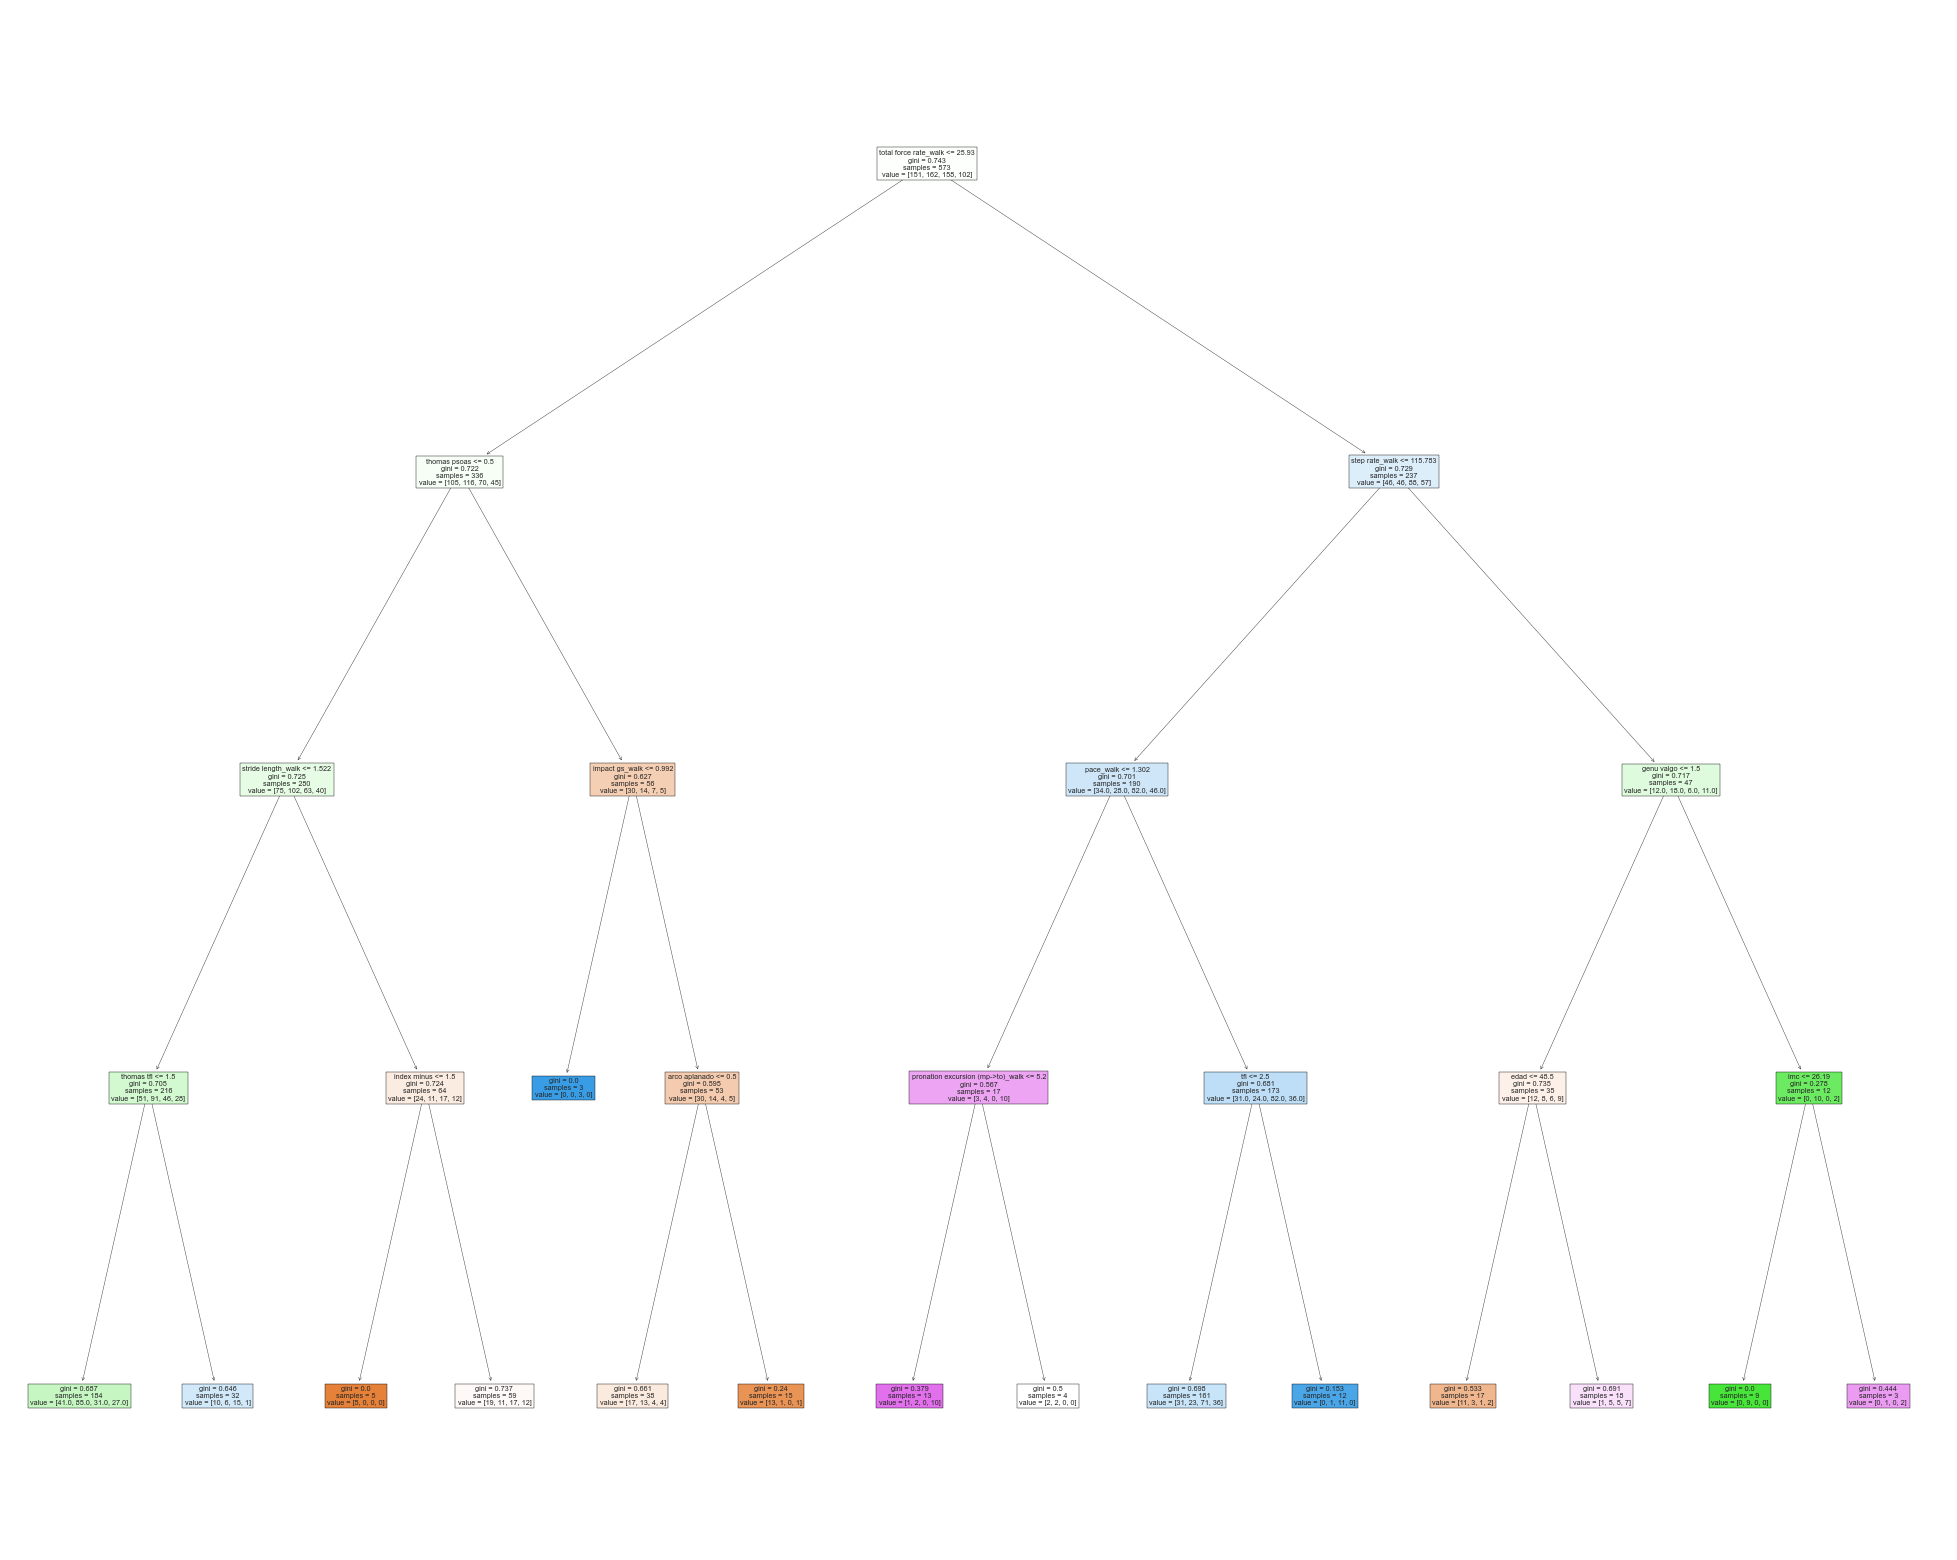

In [41]:
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_model, 
                   feature_names=X_train.columns,  
                   filled=True)

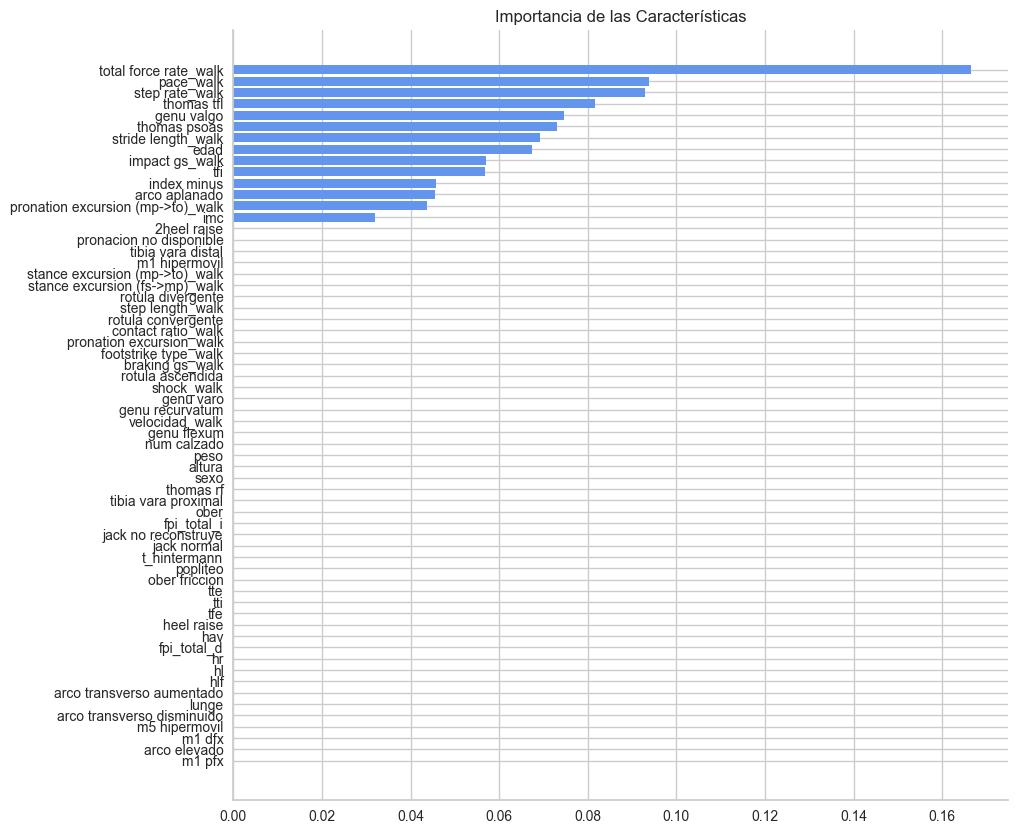

In [42]:
plot_feature_importance(best_model, X_train.columns)

### Modelo 2

Train Accuracy: 0.6684
Test Accuracy: 0.3542
Best Parameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5}


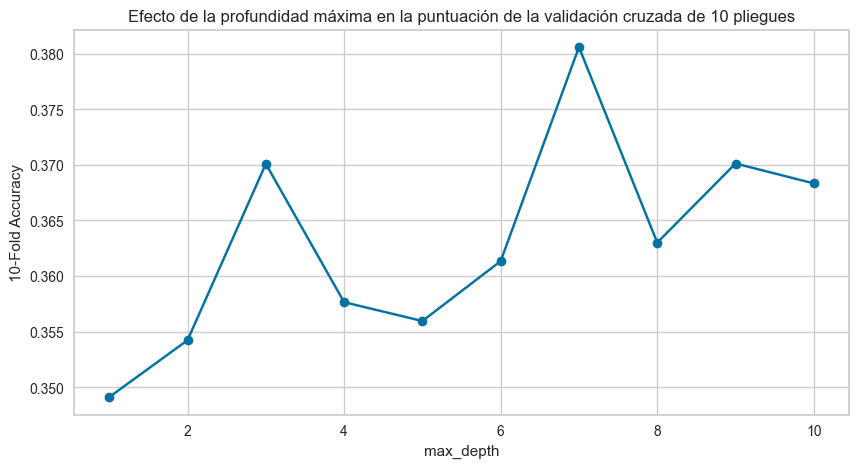

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, random_state=0, splitter='best')

In [43]:
columns = ['edad', 'sexo', 'imc', 'pace_walk', 'stride length_walk', 'impact gs_walk', 
           'total force rate_walk', 'pronation excursion (mp->to)_walk', 'stance excursion (fs->mp)_walk',
          'step rate_walk', 'thomas tfl', 'tfi', 'index minus', 'arco aplanado']

params = {'max_depth': range(1, 11), 'min_samples_split': range(2, 10), 'min_samples_leaf': range(1, 5)}

best_model_2 = train_evaluate_tree_model(X_train[columns], y_train, X_test[columns], y_test, params, cv_folds=10)
best_model_2

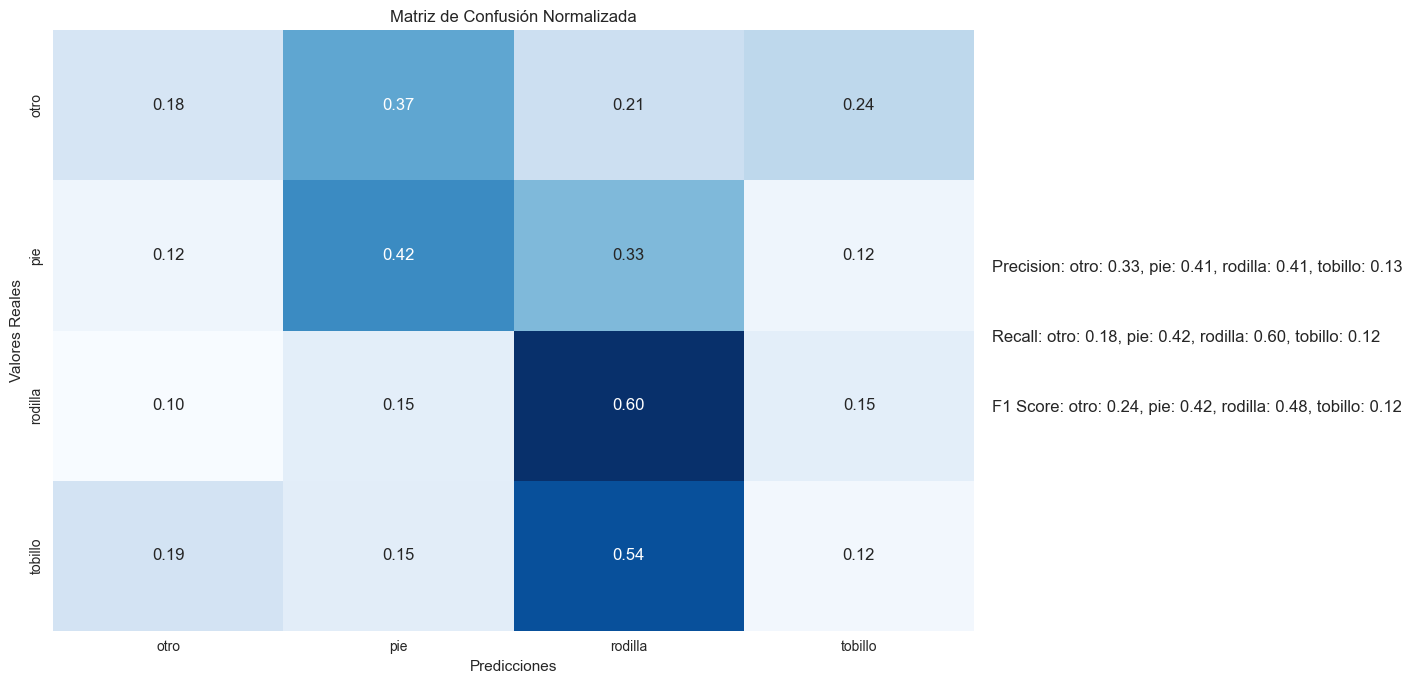


Classification Report:

              precision    recall  f1-score   support

        otro       0.33      0.18      0.24        38
         pie       0.41      0.42      0.42        40
     rodilla       0.41      0.60      0.48        40
     tobillo       0.13      0.12      0.12        26

    accuracy                           0.35       144
   macro avg       0.32      0.33      0.32       144
weighted avg       0.34      0.35      0.34       144



In [44]:
y_pred = best_model_2.predict(X_test[columns])  # Etiquetas predichas por el modelo

plot_confusion_matrix_with_metrics(y_test, y_pred)

Predicciones realizadas con éxito
Conversión a numpy arrays exitosa
Cálculo de métricas exitoso
Resultados para DecisionTreeClassifier:
Accuracy: 0.3542
Precision: 0.3213
Recall: 0.3311
F1 Score: 0.3161


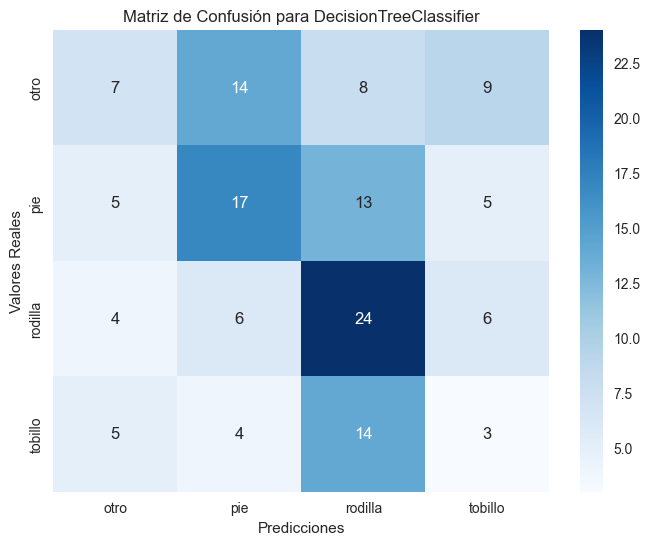

Visualización de la matriz de confusión exitosa


In [45]:
evaluate_model(best_model_2, X_test[columns], y_test)

### Modelo 3

Train Accuracy: 0.4887
Test Accuracy: 0.4306
Best Parameters: {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}


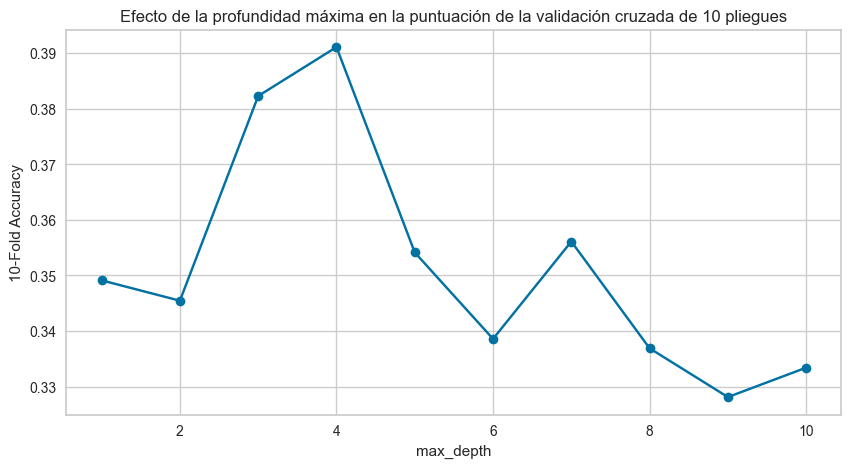

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, random_state=0, splitter='best')

In [46]:
columns = ['edad', 'sexo', 'altura', 'peso', 'num calzado', 'imc',
       'pace_walk', 'velocidad_walk', 'step rate_walk', 'stride length_walk', 'impact gs_walk', 'braking gs_walk',
       'pronation excursion_walk', 'contact ratio_walk', 'total force rate_walk', 'step length_walk',
       'pronation excursion (mp->to)_walk', 'stance excursion (fs->mp)_walk',
       'stance excursion (mp->to)_walk', 'm1 hipermovil', 'thomas psoas',
       'thomas tfl', 'arco aplanado', 'arco elevado', 'arco transverso disminuido',
       'tfi', 'tfe', 'tti', 'tte', 'popliteo', 't_hintermann', 'index minus',
       'jack normal', 'jack no reconstruye', '2heel raise', 'fpi_total_d', 'tibia vara proximal', 
       'rotula convergente', 'rotula ascendida', 'genu valgo', 'genu varo', 'lunge']

params = {'max_depth': range(1, 11), 'min_samples_split': range(2, 10), 'min_samples_leaf': range(1, 5)}

best_model_3 = train_evaluate_tree_model(X_train[columns], y_train, X_test[columns], y_test, params, cv_folds=10)
best_model_3

Predicciones realizadas con éxito
Conversión a numpy arrays exitosa
Cálculo de métricas exitoso
Resultados para DecisionTreeClassifier:
Accuracy: 0.4306
Precision: 0.3768
Recall: 0.4005
F1 Score: 0.3779


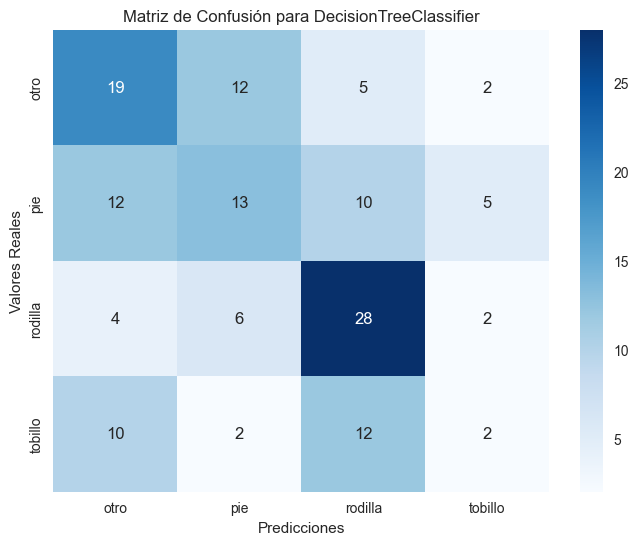

Visualización de la matriz de confusión exitosa


In [47]:
evaluate_model(best_model_3, X_test[columns], y_test)

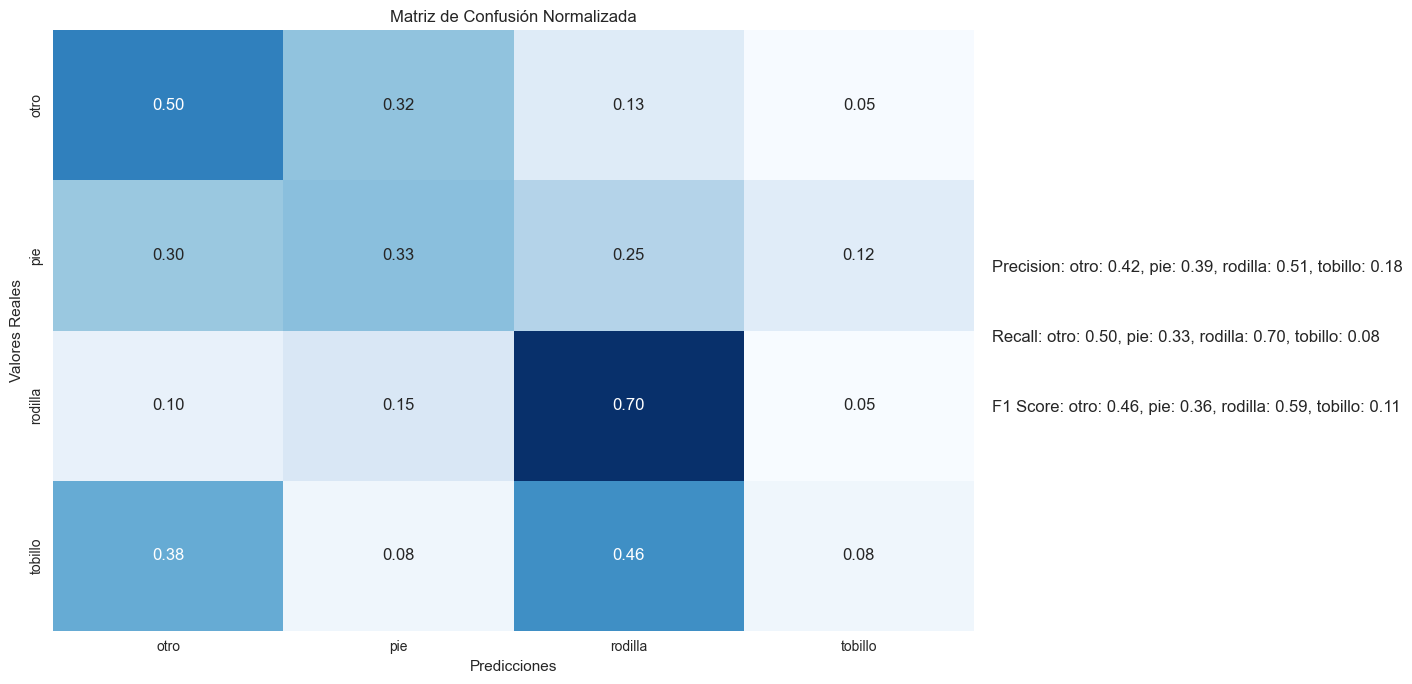


Classification Report:

              precision    recall  f1-score   support

        otro       0.42      0.50      0.46        38
         pie       0.39      0.33      0.36        40
     rodilla       0.51      0.70      0.59        40
     tobillo       0.18      0.08      0.11        26

    accuracy                           0.43       144
   macro avg       0.38      0.40      0.38       144
weighted avg       0.40      0.43      0.40       144



In [48]:
y_pred = best_model_3.predict(X_test[columns])  # Etiquetas predichas por el modelo
plot_confusion_matrix_with_metrics(y_test, y_pred)

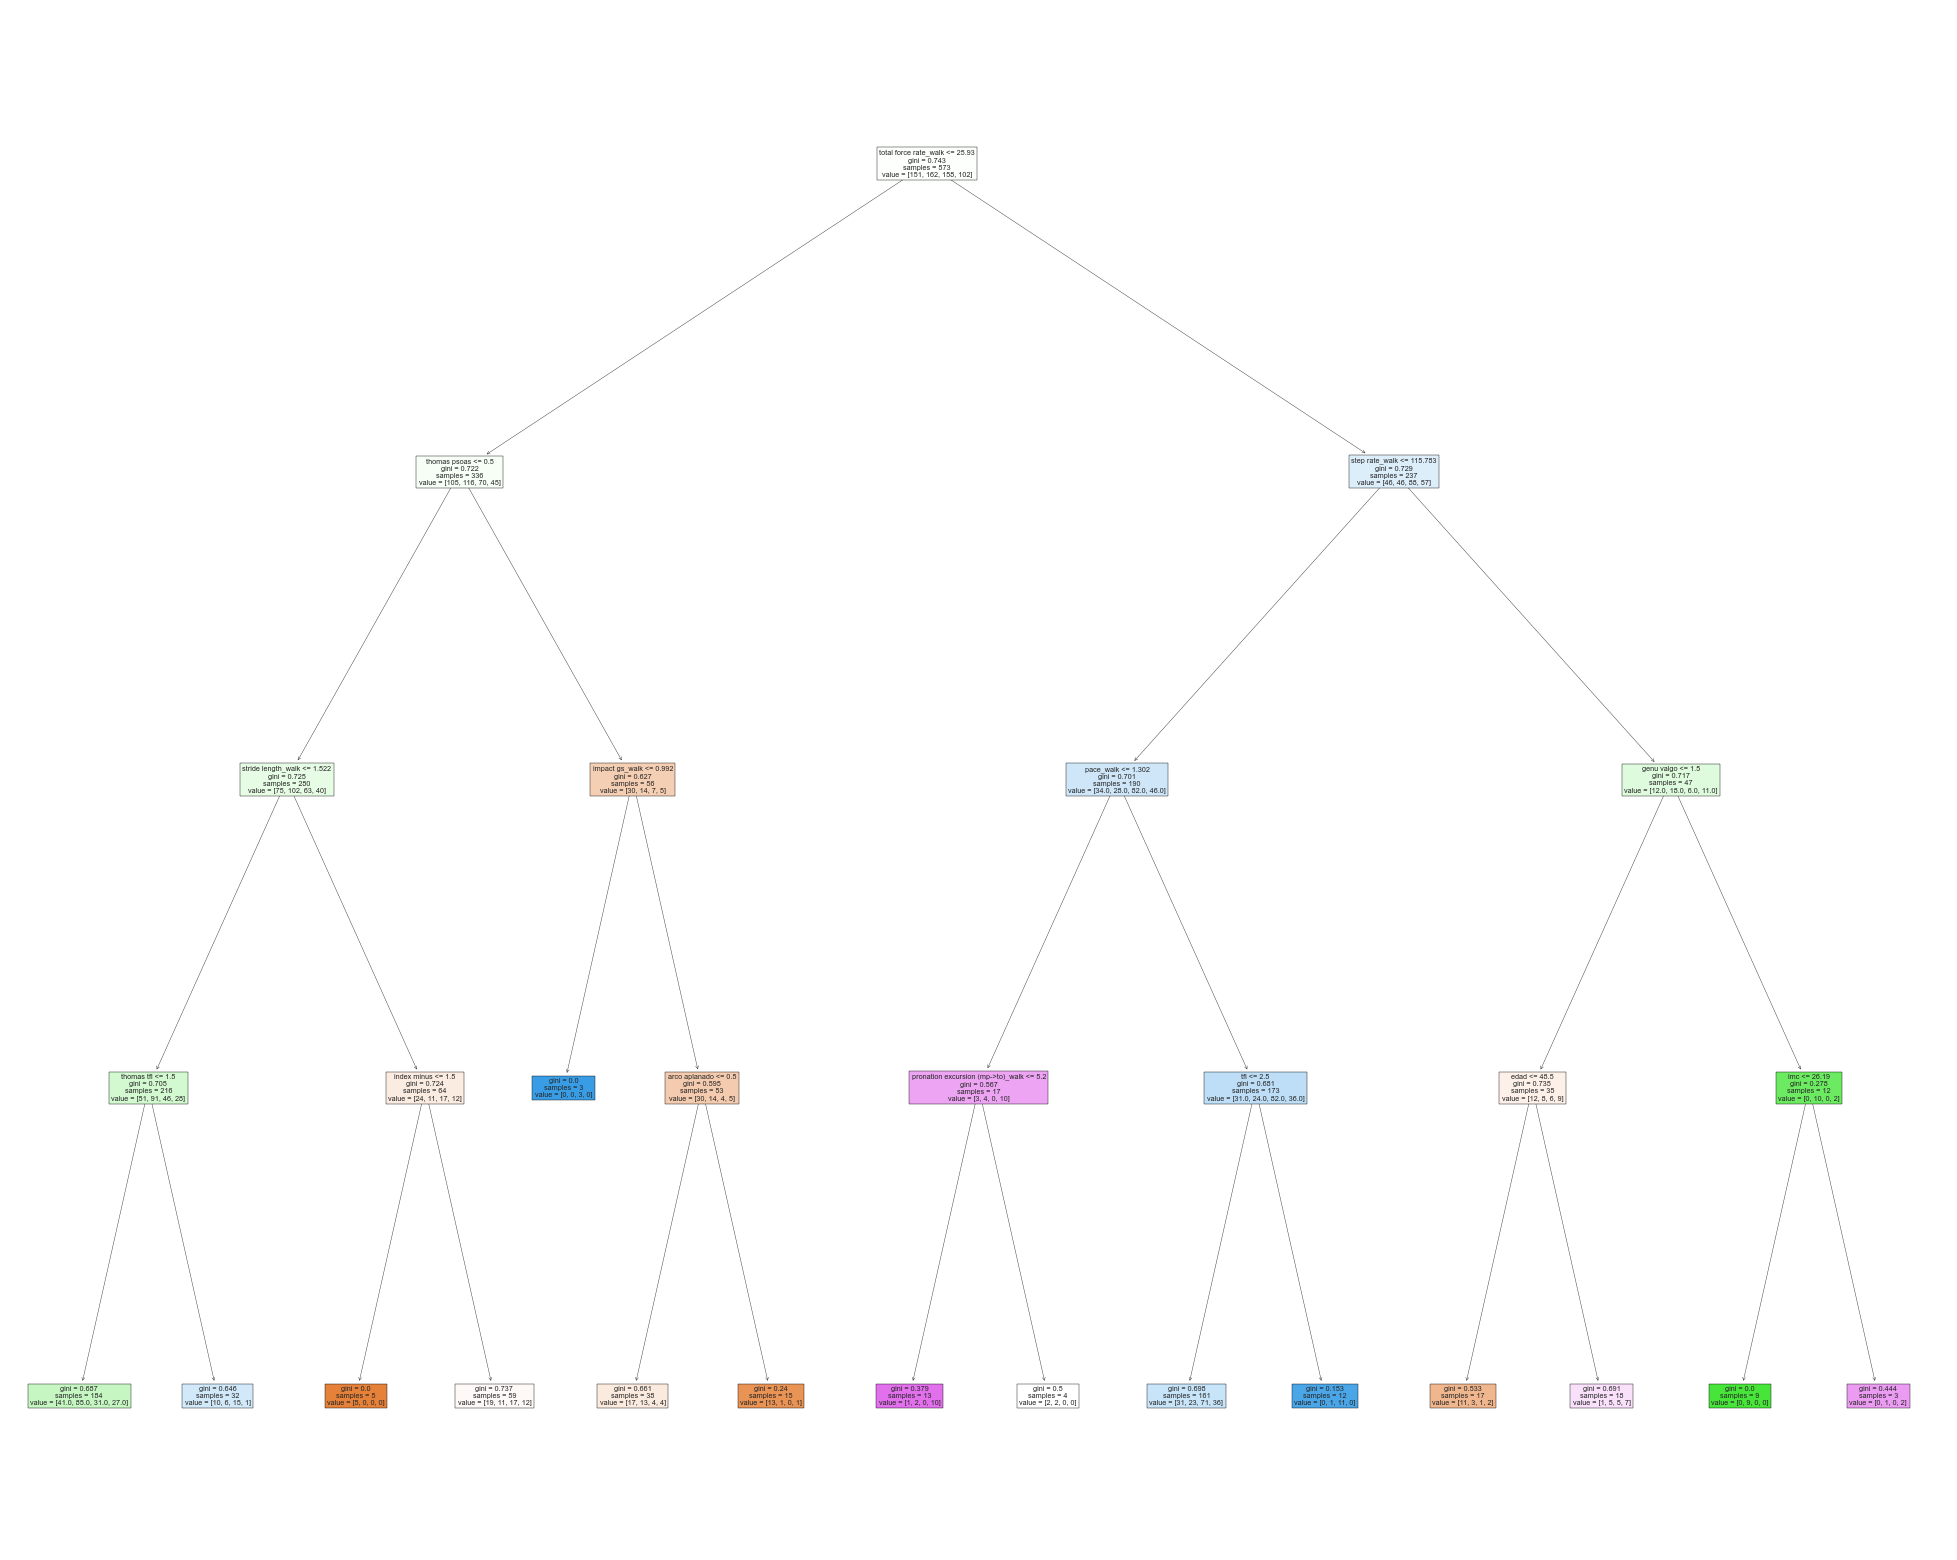

In [49]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_model_3, 
                   feature_names=columns,  
                   filled=True)

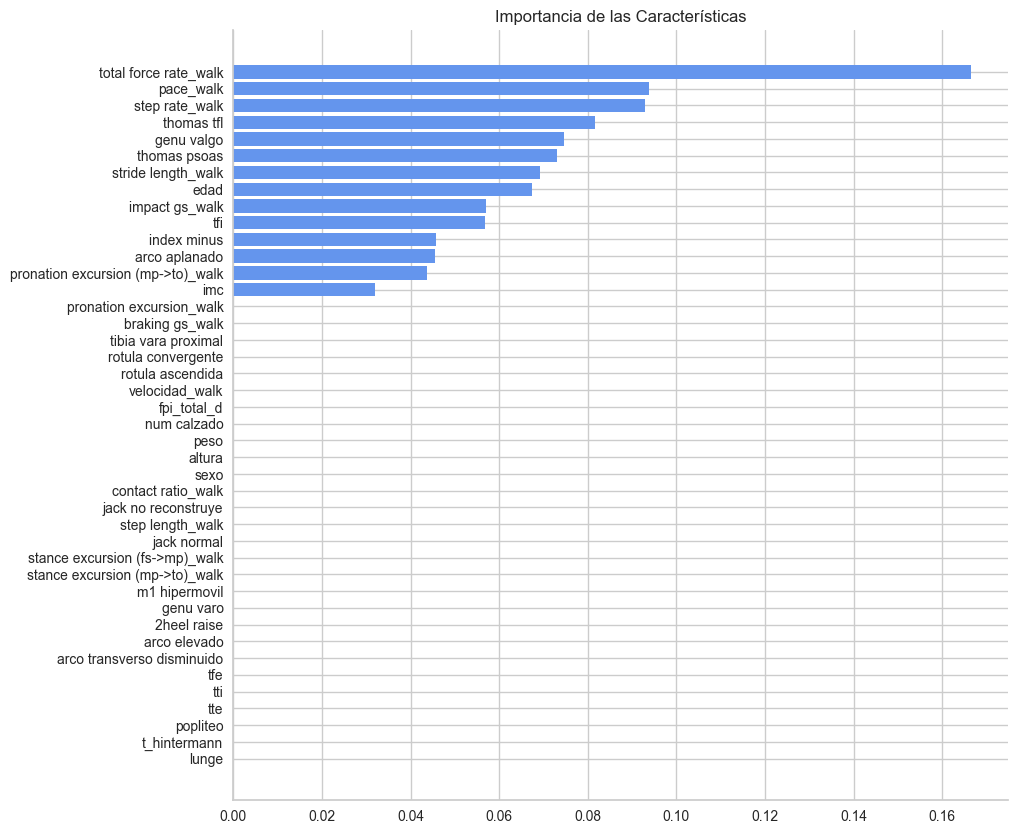

In [50]:
plot_feature_importance(best_model_3, X_train[columns].columns)

### Modelo 4

Train Accuracy: 0.4572
Test Accuracy: 0.4375
Best Parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


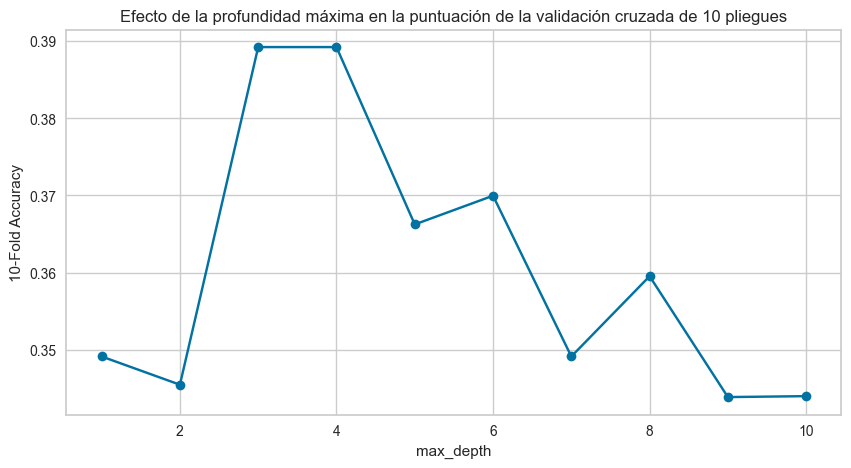

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, random_state=0, splitter='best')

In [51]:
columns = ['total force rate_walk', 'pace_walk', 'step rate_walk', 'thomas tfl', 'genu valgo',
           'pronation excursion (mp->to)_walk', 'thomas psoas', 'impact gs_walk', 'tfi', 
           'stride length_walk', 'edad', 'index minus','arco aplanado']

params = {'max_depth': range(1, 11), 'min_samples_split': range(2, 10), 'min_samples_leaf': range(1, 5)}

best_model_4 = train_evaluate_tree_model(X_train[columns], y_train, X_test[columns], y_test, params, cv_folds=10)
best_model_4

Predicciones realizadas con éxito
Conversión a numpy arrays exitosa
Cálculo de métricas exitoso
Resultados para DecisionTreeClassifier:
Accuracy: 0.4375
Precision: 0.3388
Recall: 0.4000
F1 Score: 0.3663


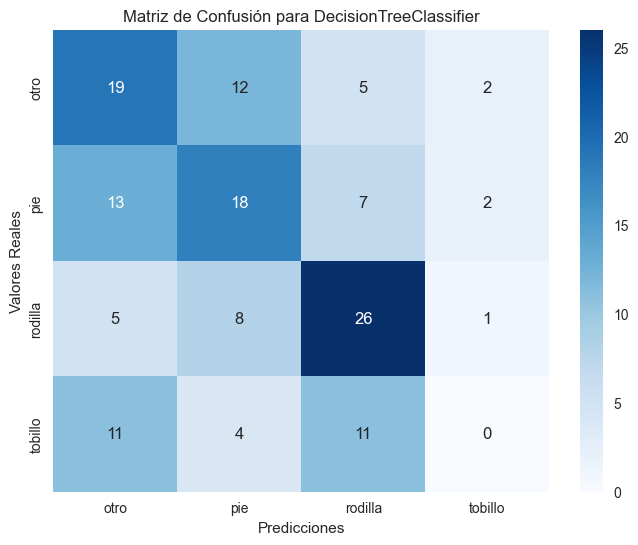

Visualización de la matriz de confusión exitosa


In [52]:
evaluate_model(best_model_4, X_test[columns], y_test)

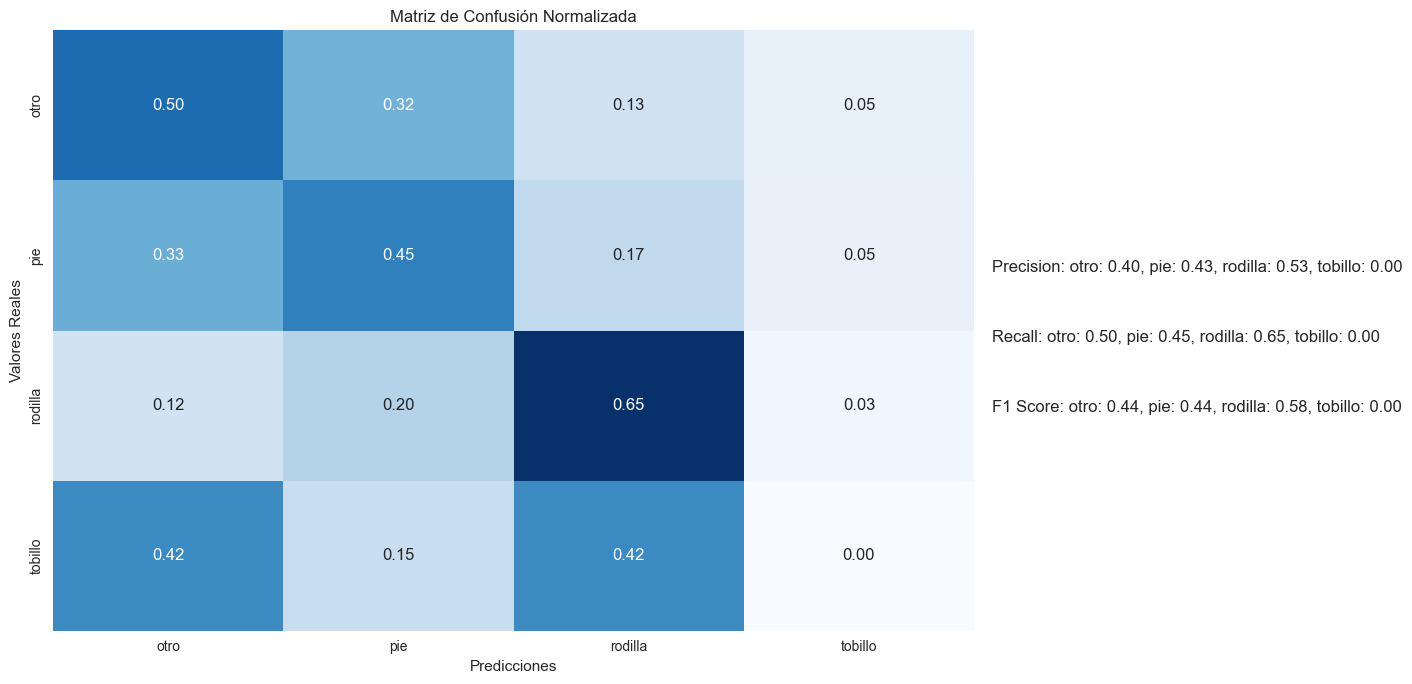


Classification Report:

              precision    recall  f1-score   support

        otro       0.40      0.50      0.44        38
         pie       0.43      0.45      0.44        40
     rodilla       0.53      0.65      0.58        40
     tobillo       0.00      0.00      0.00        26

    accuracy                           0.44       144
   macro avg       0.34      0.40      0.37       144
weighted avg       0.37      0.44      0.40       144



In [53]:
y_pred = best_model_4.predict(X_test[columns])  # Etiquetas predichas por el modelo
plot_confusion_matrix_with_metrics(y_test, y_pred)

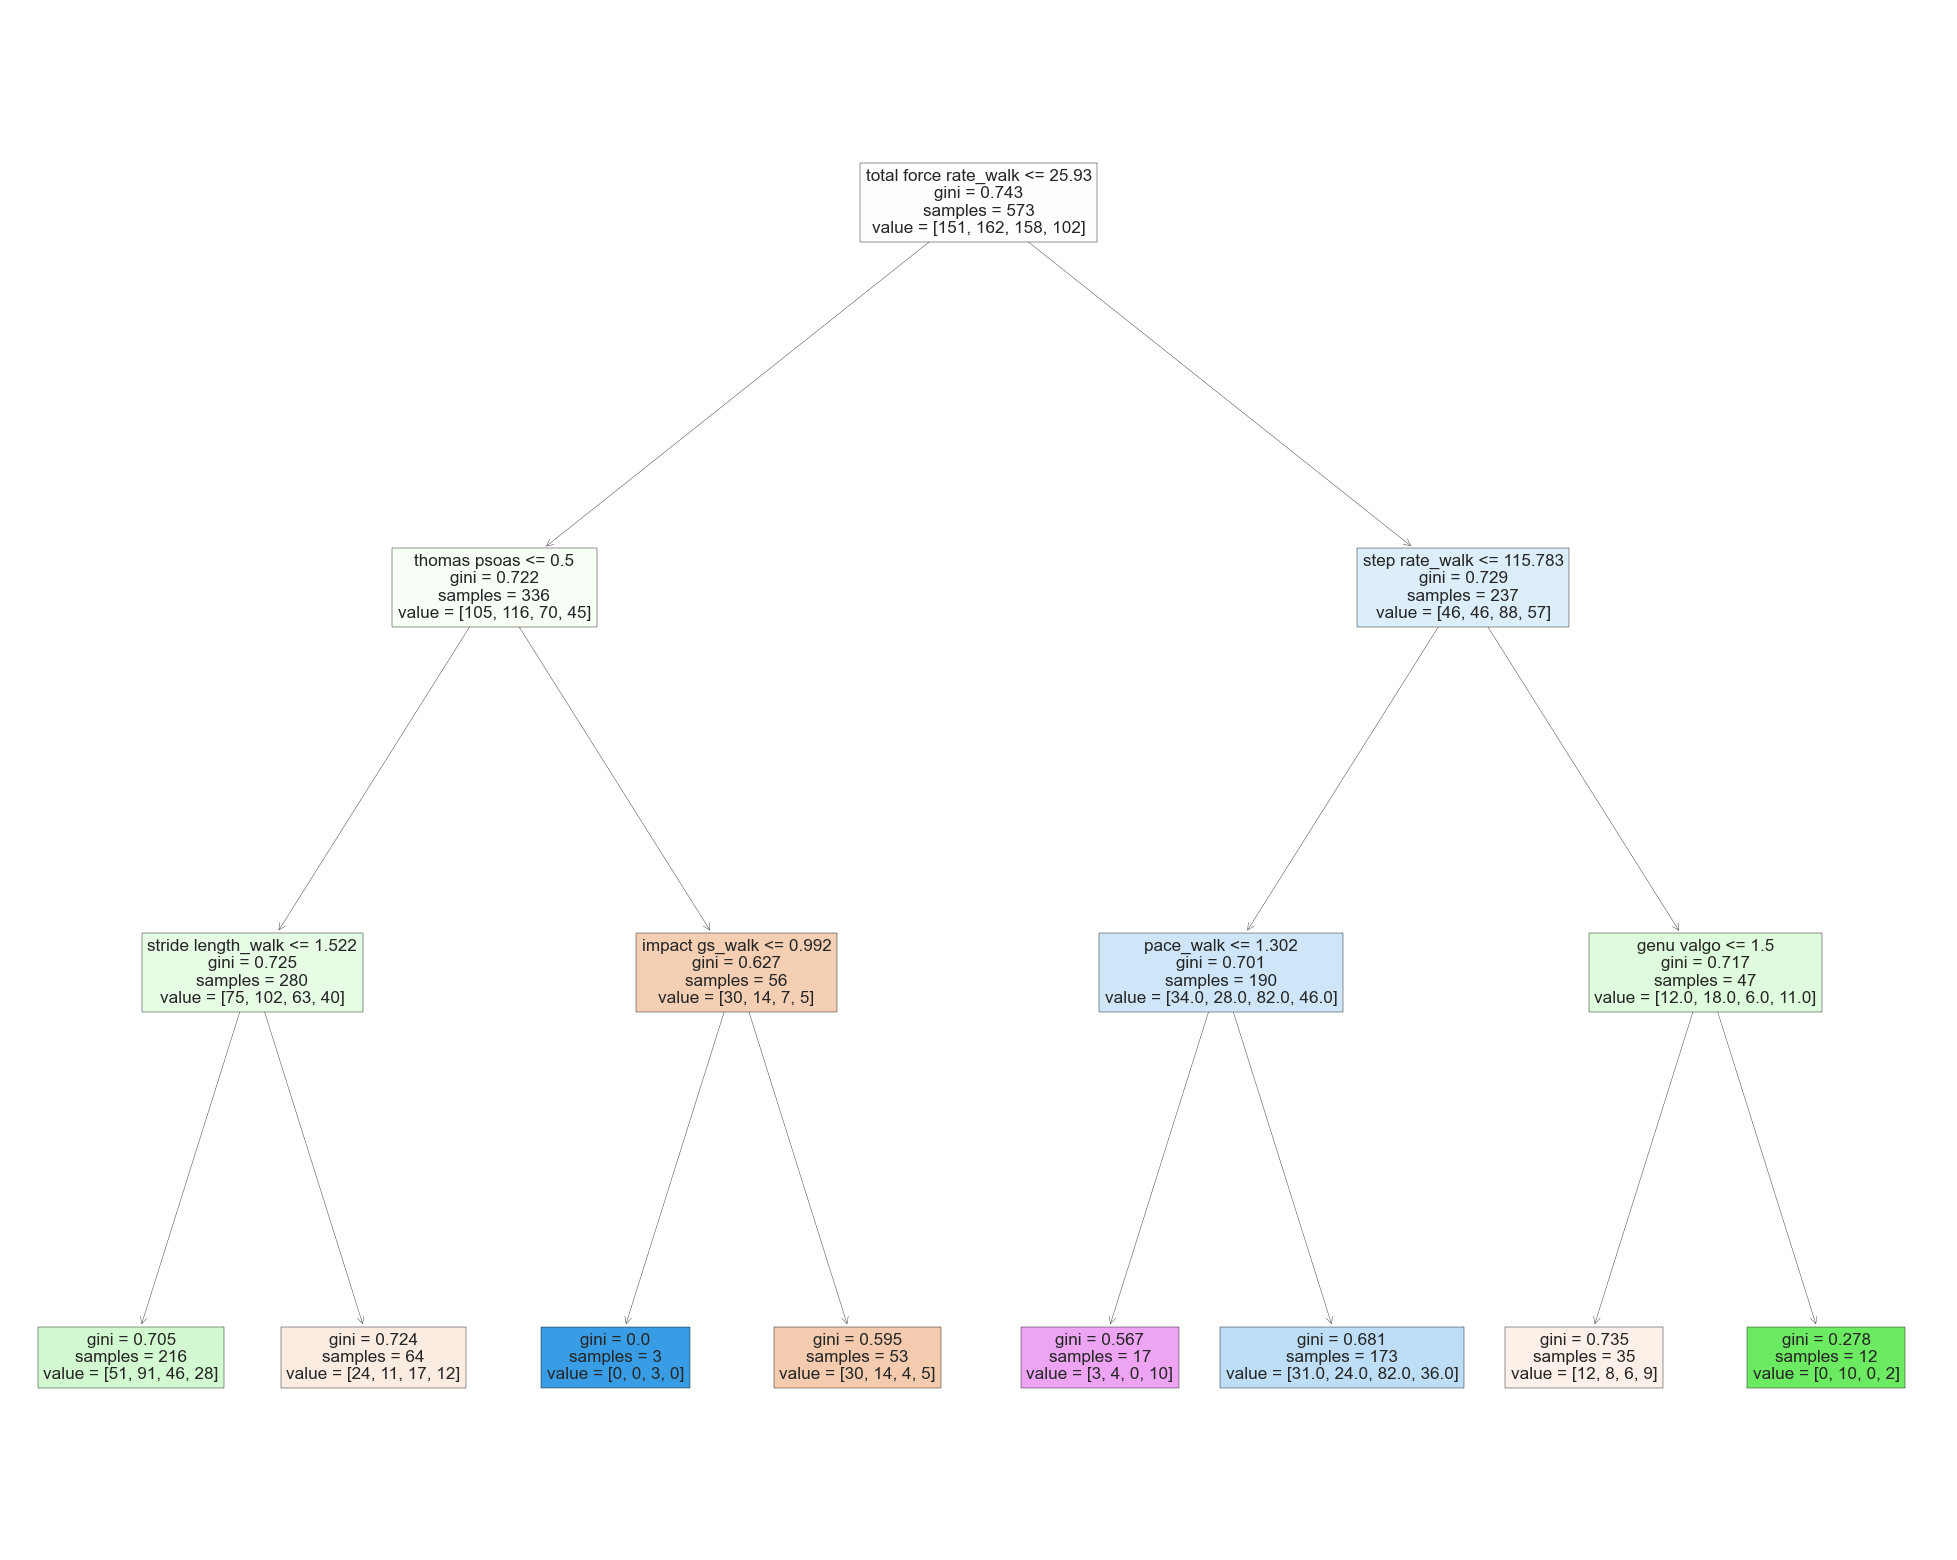

In [54]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_model_4, 
                   feature_names=columns,  
                   filled=True)

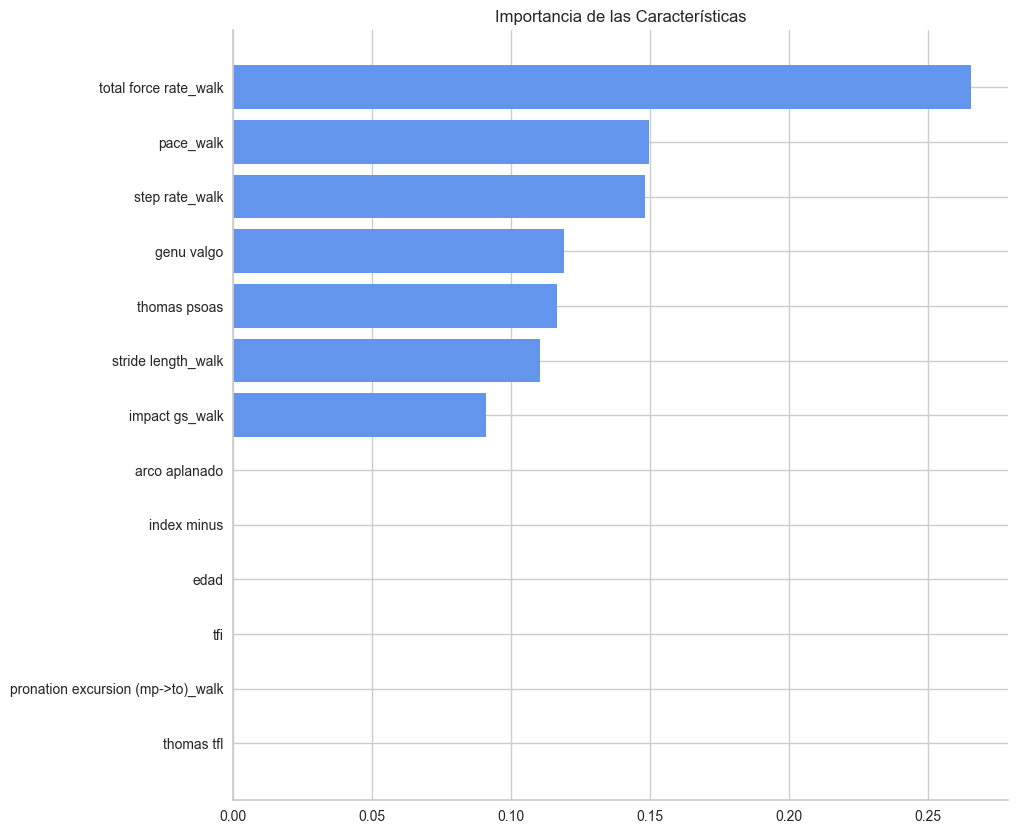

In [55]:
plot_feature_importance(best_model_4, X_train[columns].columns)

### Evaluación de Modelos

**1. Modelo 1 y Modelo 3:**
   - **Train Accuracy:** 0.4887
   - **Test Accuracy:** 0.4306
   - **Precision:** 0.3768 (macro avg), 0.40 (weighted avg)
   - **Recall:** 0.4005 (macro avg), 0.43 (weighted avg)
   - **F1 Score:** 0.3779 (macro avg), 0.40 (weighted avg)

   Ambos modelos son idénticos en términos de parámetros y métricas de desempeño, mostrando una precisión y recall moderados en comparación con los otros modelos. Son consistentes en términos de desempeño tanto en entrenamiento como en prueba.

**2. Modelo 2:**
   - **Train Accuracy:** 0.6684 (más alto entre los modelos)
   - **Test Accuracy:** 0.3542 (el más bajo)
   - **Precision:** 0.3213 (macro avg), 0.34 (weighted avg)
   - **Recall:** 0.3311 (macro avg), 0.35 (weighted avg)
   - **F1 Score:** 0.3161 (macro avg), 0.34 (weighted avg)

   Aunque este modelo tiene la mayor precisión en el conjunto de entrenamiento, su rendimiento cae significativamente en el conjunto de prueba, indicando un posible **sobreajuste**.

**3. Modelo 4:**
   - **Train Accuracy:** 0.4572
   - **Test Accuracy:** 0.4375 (el más alto entre los modelos)
   - **Precision:** 0.3388 (macro avg), 0.37 (weighted avg)
   - **Recall:** 0.4000 (macro avg), 0.44 (weighted avg)
   - **F1 Score:** 0.3663 (macro avg), 0.40 (weighted avg)

   Este modelo tiene la mayor precisión en el conjunto de prueba y muestra una mejora leve sobre los modelos 1 y 3, aunque hay un desequilibrio significativo en la precisión y recall entre las categorías, destacando un desempeño pobre en la categoría 'tobillo' donde no se identificó correctamente ningún caso.

### Conclusión

El **Modelo 4** parece ser el más prometedor en términos de precisión general de prueba y manejo del desequilibrio entre las categorías de la variable objetivo. Aunque la precisión macro promedio es más baja, muestra la precisión más alta y consistente en el conjunto de prueba, lo que sugiere que es más robusto y generaliza mejor sobre datos no vistos en comparación con los otros modelos.

#### Razones para Elegir el Modelo 4

- **Selección de Características**: El Modelo 4 utiliza un conjunto de características que incluye algunas de las más influyentes según los análisis de importancia de características (como `total force rate_walk`, `pace_walk`, `stride length_walk`, y `impact gs_walk`). Esta selección parece proporcionar un buen equilibrio entre la cantidad de información y el rendimiento del modelo, evitando posiblemente el sobreajuste que podríamos ver en el Modelo 1 que usa todas las características.

- **Rendimiento General**: A pesar de que el Modelo 4 no tiene la mayor precisión en los entrenamientos (como el Modelo 2), muestra la mejor precisión de prueba, lo que indica que generaliza mejor en datos no vistos.

- **Complejidad del Modelo**: El Modelo 4, con una selección más enfocada de características, probablemente sea menos complejo y más interpretable que el Modelo 1, que usa todas las características.

- **Balanced Feature Set**: La elección de las características en el Modelo 4 parece estar bien equilibrada para capturar tanto los aspectos biomecánicos (ej., `stride length_walk`, `total force rate_walk`) como los factores de riesgo o condicionantes personales (ej., `edad`, `genu valgo`).

# Random Forest

### Modelo 1 - Sin Selección de Características

Fitting 3 folds for each of 112 candidates, totalling 336 fits
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=1, max_fe

[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2; total tim

[CV] END max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total tim

[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=11, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=11, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=11, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=11, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=11, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=11, max_features=log2, min_samples_leaf=1, min_samples_split=5;

[CV] END max_depth=14, max_features=log2, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END max_depth=14, max_features=log2, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END max_depth=14, max_features=log2, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END max_depth=14, max_features=log2, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=14, max_features=log2, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=14, max_features=log2, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
Best mean cross-validation score: 0.366
Best parameters: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2}


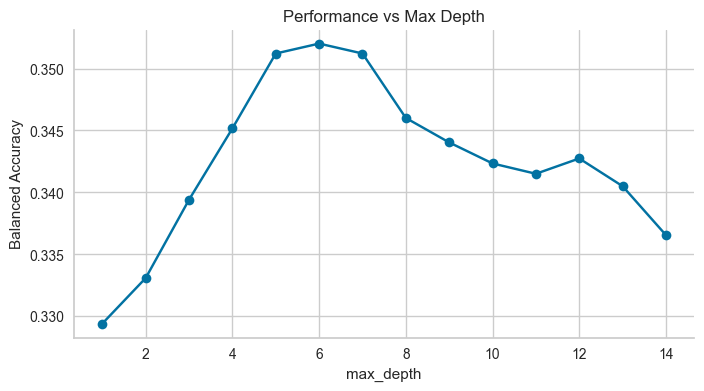

In [57]:
param_grid = {
    'max_depth': range(1, 15),
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf = train_random_forest(X_train, y_train, X_train.columns, param_grid, n_jobs=1, cv=3)

Predicciones realizadas con éxito
Conversión a numpy arrays exitosa
Cálculo de métricas exitoso
Resultados para RandomForestClassifier:
Accuracy: 0.3819
Precision: 0.3526
Recall: 0.3557
F1 Score: 0.3457


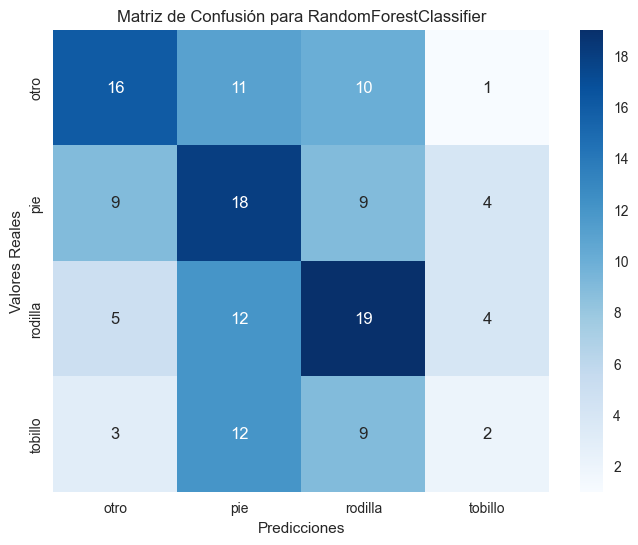

Visualización de la matriz de confusión exitosa


In [58]:
evaluate_model(rf, X_test, y_test)

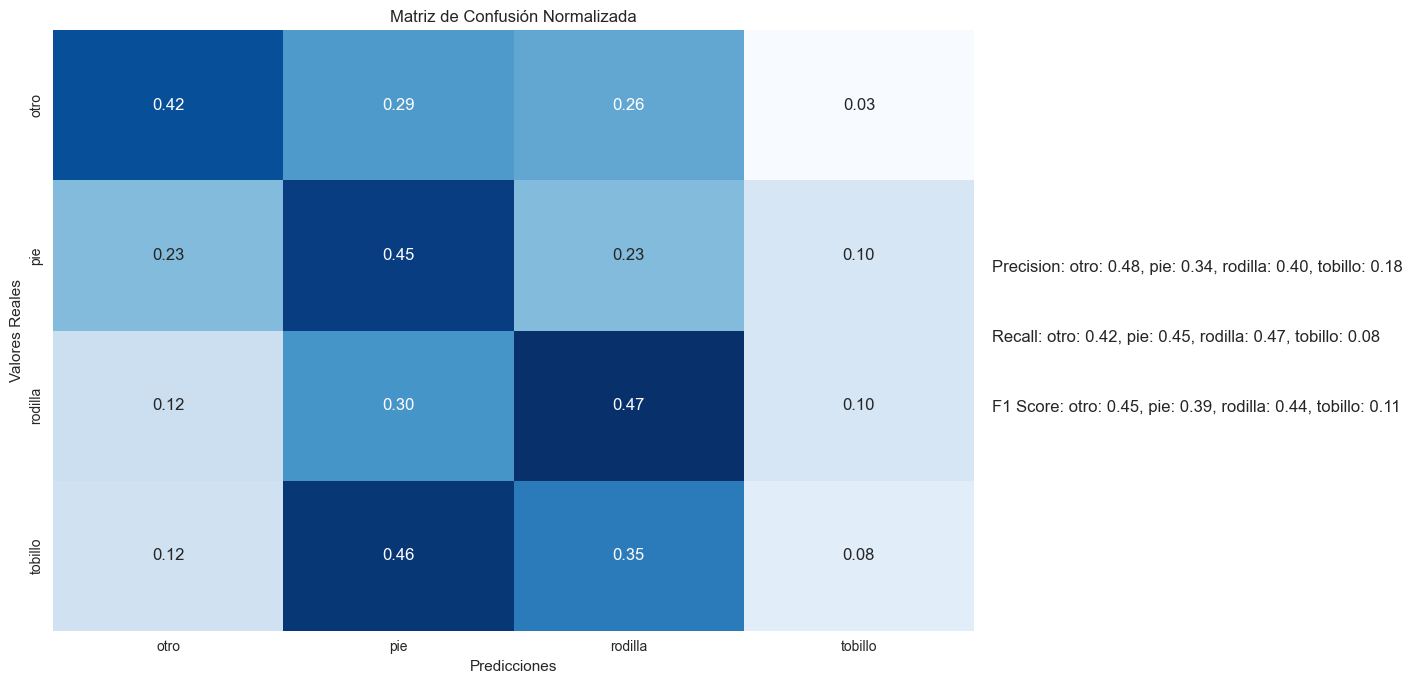


Classification Report:

              precision    recall  f1-score   support

        otro       0.48      0.42      0.45        38
         pie       0.34      0.45      0.39        40
     rodilla       0.40      0.47      0.44        40
     tobillo       0.18      0.08      0.11        26

    accuracy                           0.38       144
   macro avg       0.35      0.36      0.35       144
weighted avg       0.37      0.38      0.37       144



In [59]:
y_pred = rf.predict(X_test)  # Etiquetas predichas por el modeloModel
plot_confusion_matrix_with_metrics(y_test, y_pred)

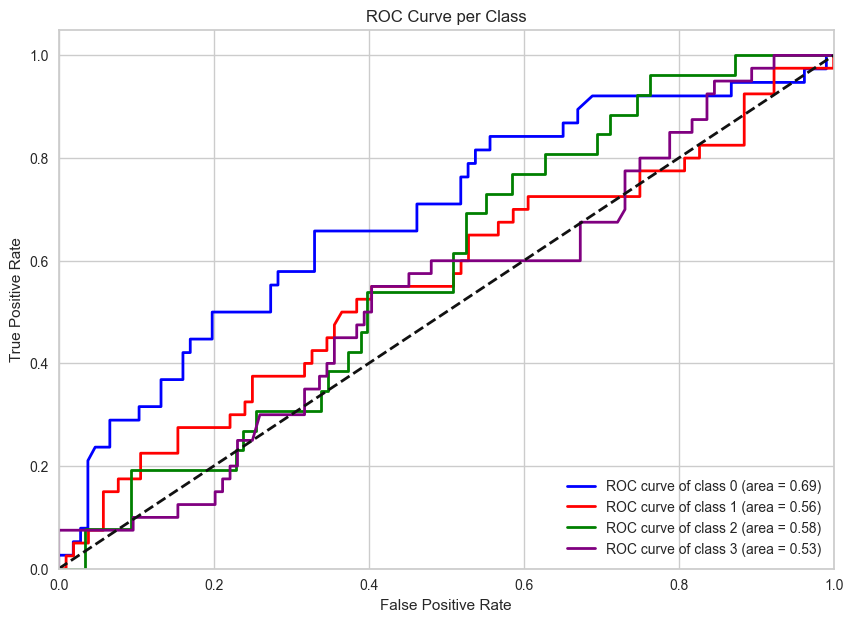

In [60]:
plot_multiclass_roc(rf, X_test, y_test)

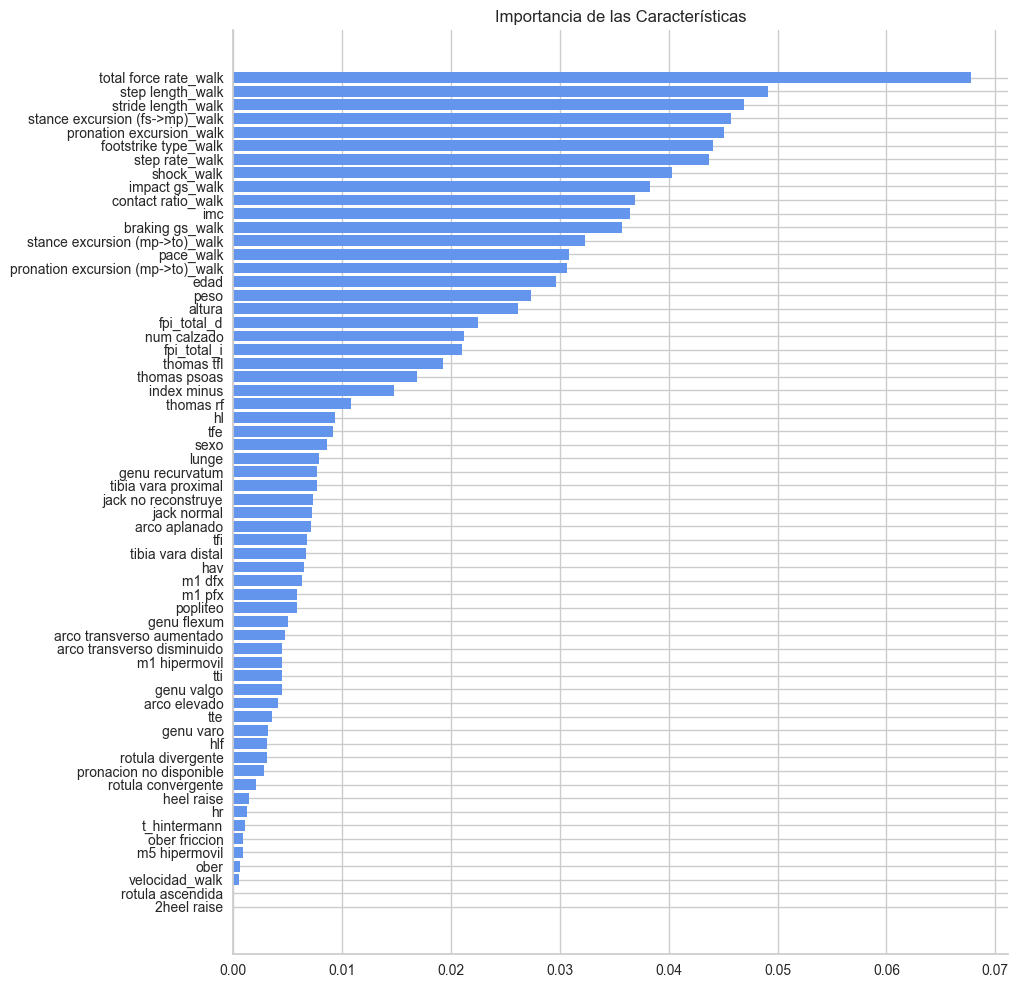

In [61]:
plot_feature_importance(rf, X_train.columns, figsize=(10,12))

### Modelo 2 - Con Selección de Características

Fitting 3 folds for each of 112 candidates, totalling 336 fits
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=1, max_fe

[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2; total tim

[CV] END max_depth=7, max_features=log2, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total tim

[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=11, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=11, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=11, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=11, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=11, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=11, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=11, max_features=log2, min_samples_leaf=2, min_samples_split=2;

[CV] END max_depth=14, max_features=log2, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=14, max_features=log2, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=14, max_features=log2, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
Best mean cross-validation score: 0.379
Best parameters: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}


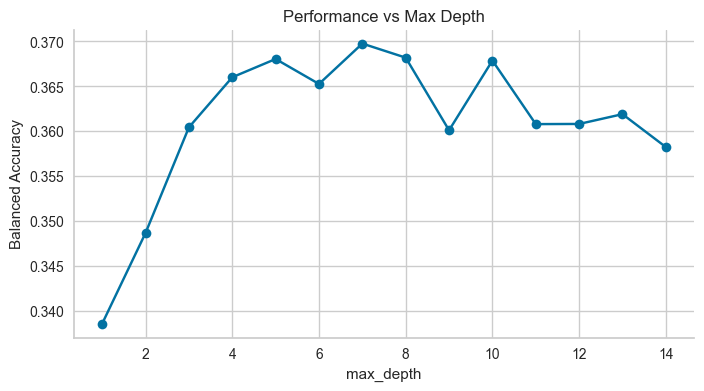

In [87]:
columns = ['total force rate_walk', 'pace_walk', 'step rate_walk', 'thomas tfl', 'genu valgo',
           'pronation excursion (mp->to)_walk', 'thomas psoas', 'impact gs_walk', 'tfi', 'contact ratio_walk',
           'stride length_walk', 'edad', 'index minus','arco aplanado', 'stance excursion (fs->mp)_walk']

param_grid = {
    'max_depth': range(1, 15),
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf2 = train_random_forest(X_train, y_train, columns, param_grid, n_jobs=1, cv=3)

Predicciones realizadas con éxito
Conversión a numpy arrays exitosa
Cálculo de métricas exitoso
Resultados para RandomForestClassifier:
Accuracy: 0.4028
Precision: 0.3857
Recall: 0.3812
F1 Score: 0.3757


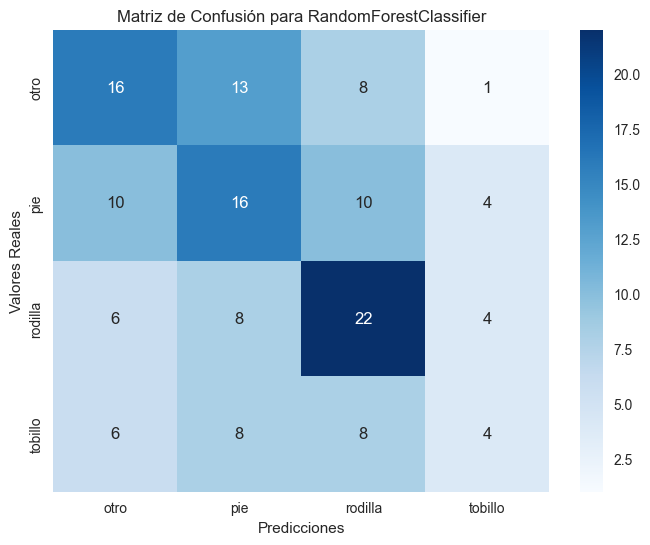

Visualización de la matriz de confusión exitosa


In [63]:
evaluate_model(rf2, X_test[columns], y_test)

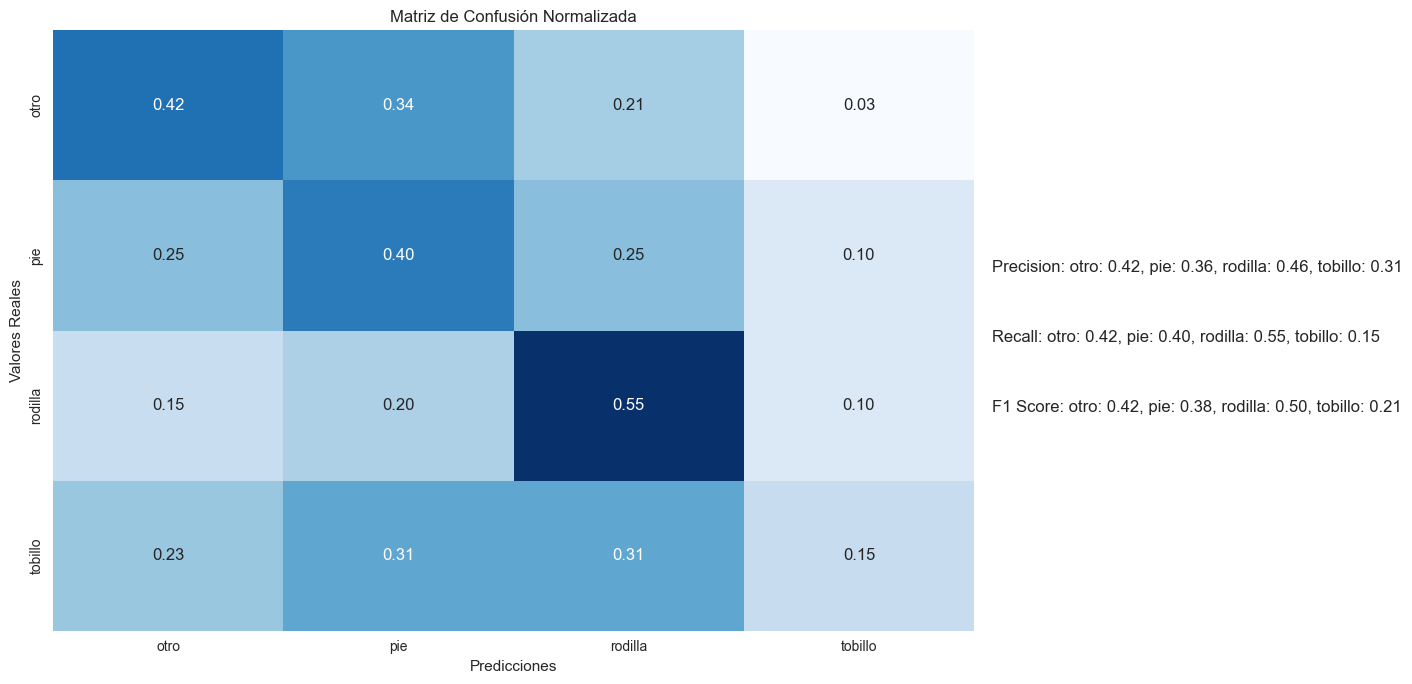


Classification Report:

              precision    recall  f1-score   support

        otro       0.42      0.42      0.42        38
         pie       0.36      0.40      0.38        40
     rodilla       0.46      0.55      0.50        40
     tobillo       0.31      0.15      0.21        26

    accuracy                           0.40       144
   macro avg       0.39      0.38      0.38       144
weighted avg       0.39      0.40      0.39       144



In [64]:
y_pred = rf2.predict(X_test[columns])  # Etiquetas predichas por el modeloModel
plot_confusion_matrix_with_metrics(y_test, y_pred)

In [88]:
# Evaluación del modelo
train_accuracy = rf2.score(X_train[columns], y_train)
test_accuracy = rf2.score(X_test[columns], y_test)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.8517
Test Accuracy: 0.4028


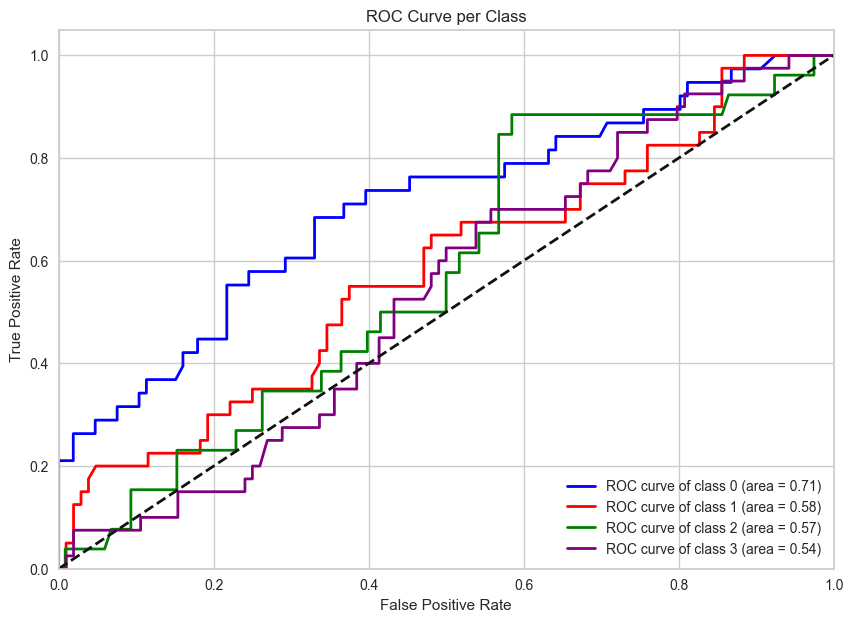

In [65]:
plot_multiclass_roc(rf2, X_test[columns], y_test)

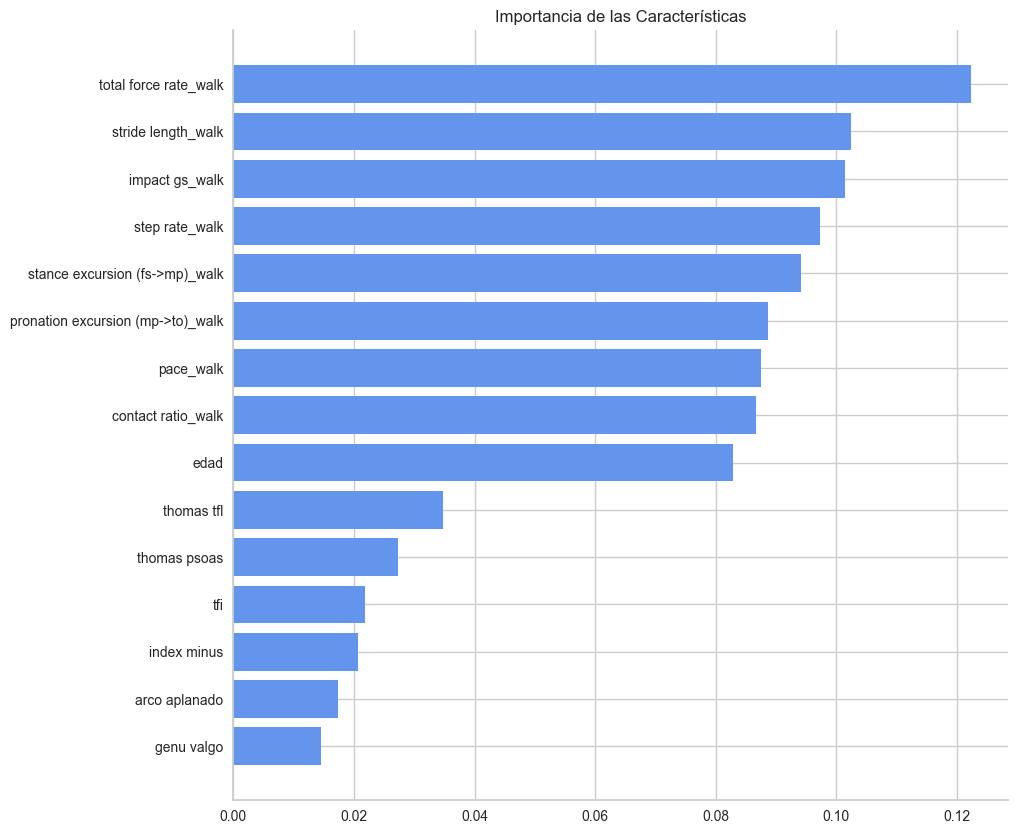

In [66]:
plot_feature_importance(rf2, X_train[columns].columns)

### Observaciones

- La categoría "rodilla" muestra el mejor recall, lo que indica que el modelo es relativamente más eficaz en detectar esta categoría.
- Las categorías "otro" y "pie" tienen un rendimiento moderado.
- La categoría "tobillo" muestra un rendimiento bajo, especialmente en términos de recall, lo que sugiere que el modelo lucha por identificar correctamente esta categoría.

Fitting 5 folds for each of 112 candidates, totalling 560 fits
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=1, max_fe

[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total tim

[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total tim

[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total tim

[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=9, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=9, max_features=log2, min_samples_leaf=1, min_samples_split=2; total tim

[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=11, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=11, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=11, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=11, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=11, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=11, max_features=log2, min_samples_leaf=1, min_samples_split=5;

[CV] END max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=5;

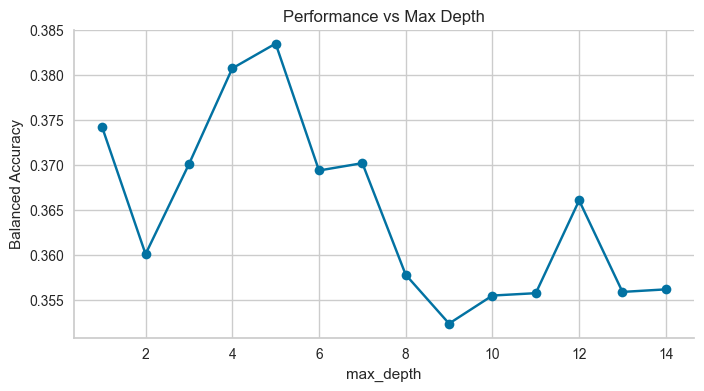

In [68]:
columns = ['total force rate_walk', 'pace_walk', 'step rate_walk', 'thomas tfl', 'genu valgo',
           'pronation excursion (mp->to)_walk', 'thomas psoas', 'impact gs_walk', 'tfi', 'contact ratio_walk',
           'stride length_walk', 'edad', 'index minus','arco aplanado', 'stance excursion (fs->mp)_walk']

param_grid = {
    'max_depth': range(1, 15),
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf2 = train_random_forest_2(X_train, y_train, columns, param_grid, cv=5, n_jobs=1)

Predicciones realizadas con éxito
Conversión a numpy arrays exitosa
Cálculo de métricas exitoso
Resultados para RandomForestClassifier:
Accuracy: 0.4306
Precision: 0.4287
Recall: 0.4338
F1 Score: 0.4305


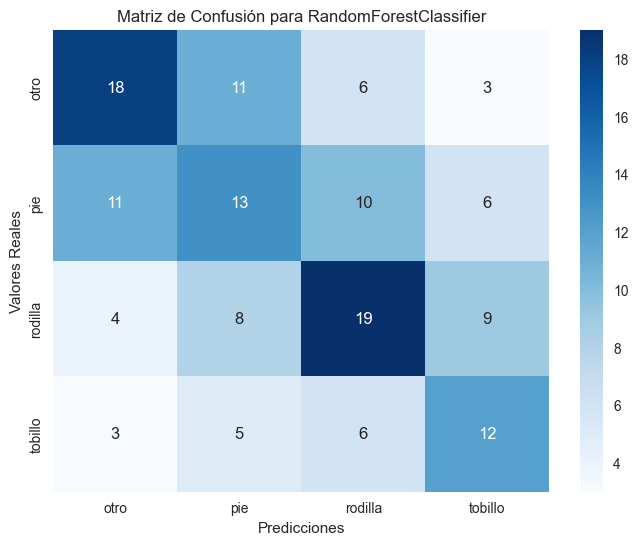

Visualización de la matriz de confusión exitosa


In [69]:
evaluate_model(rf2, X_test[columns], y_test)

### Modelo 2 con RandomisedSearchCV

In [89]:
columns = ['total force rate_walk', 'pace_walk', 'step rate_walk', 'thomas tfl', 'genu valgo',
           'pronation excursion (mp->to)_walk', 'thomas psoas', 'impact gs_walk', 'tfi', 'contact ratio_walk',
           'stride length_walk', 'edad', 'index minus','arco aplanado', 'stance excursion (fs->mp)_walk']

params = {
    'max_depth': range(1, 15),
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf3 = train_random_forest_randomized(X_train, y_train, columns, params, cv=5,  n_jobs=1)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=9, max_fe

[CV] END max_depth=7, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=5; tot

[CV] END max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total tim

[CV] END max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total 

[CV] END max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; tota

[CV] END max_depth=12, max_features=log2, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=12, max_features=log2, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=12, max_features=log2, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; tota

[CV] END max_depth=11, max_features=log2, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=11, max_features=log2, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
Best mean cross-validation score: 0.390
Best parameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 5}


Predicciones realizadas con éxito
Conversión a numpy arrays exitosa
Cálculo de métricas exitoso
Resultados para RandomForestClassifier:
Accuracy: 0.4306
Precision: 0.4287
Recall: 0.4338
F1 Score: 0.4305


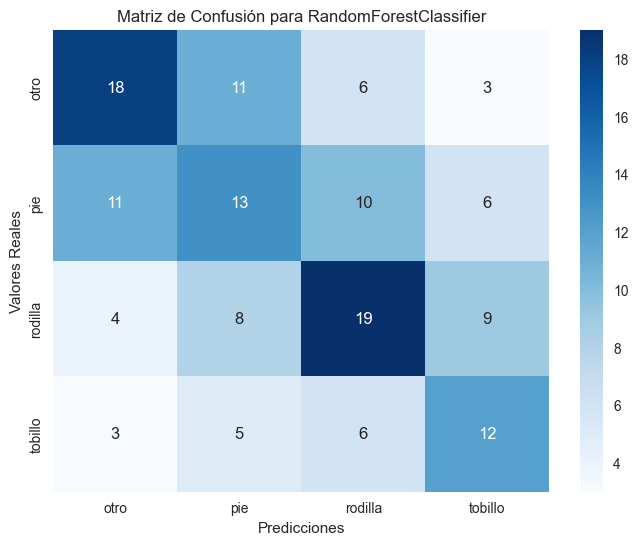

Visualización de la matriz de confusión exitosa


In [72]:
evaluate_model(rf3, X_test[columns], y_test)

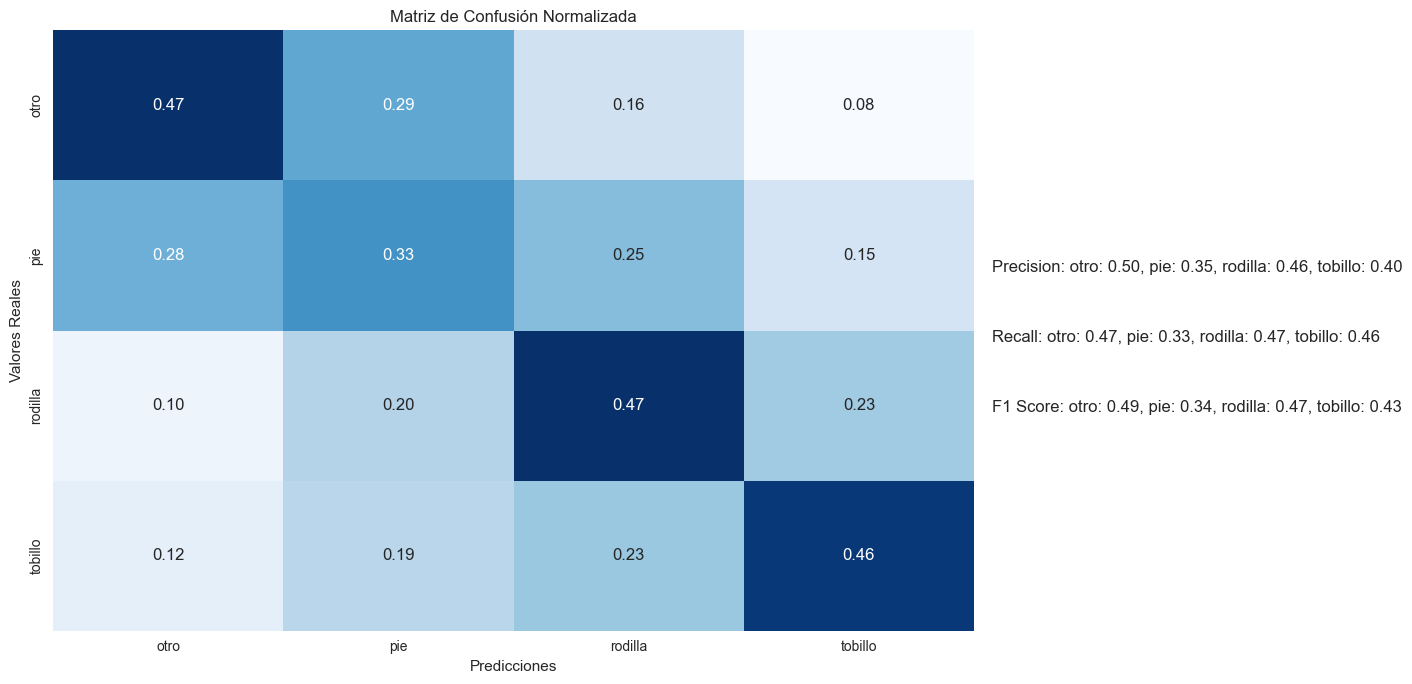


Classification Report:

              precision    recall  f1-score   support

        otro       0.50      0.47      0.49        38
         pie       0.35      0.33      0.34        40
     rodilla       0.46      0.47      0.47        40
     tobillo       0.40      0.46      0.43        26

    accuracy                           0.43       144
   macro avg       0.43      0.43      0.43       144
weighted avg       0.43      0.43      0.43       144



In [73]:
y_pred = rf3.predict(X_test[columns])  # Etiquetas predichas por el modeloModel
plot_confusion_matrix_with_metrics(y_test, y_pred)

In [90]:
# Evaluación del modelo
train_accuracy = rf3.score(X_train[columns], y_train)
test_accuracy = rf3.score(X_test[columns], y_test)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.6719
Test Accuracy: 0.4306


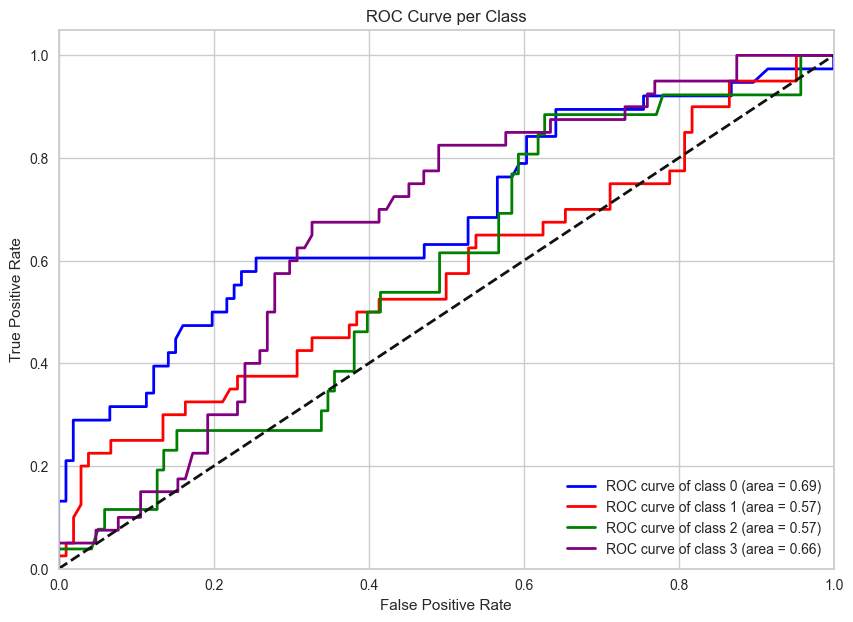

In [74]:
plot_multiclass_roc(rf3, X_test[columns], y_test)

## Bagging Classifier

Fitting 10 folds for each of 14 candidates, totalling 140 fits
[CV] END .............................estimator__max_depth=1; total time=   0.4s
[CV] END .............................estimator__max_depth=1; total time=   0.4s
[CV] END .............................estimator__max_depth=1; total time=   0.4s
[CV] END .............................estimator__max_depth=1; total time=   0.4s
[CV] END .............................estimator__max_depth=1; total time=   0.4s
[CV] END .............................estimator__max_depth=1; total time=   0.4s
[CV] END .............................estimator__max_depth=1; total time=   0.4s
[CV] END .............................estimator__max_depth=1; total time=   0.4s
[CV] END .............................estimator__max_depth=1; total time=   0.4s
[CV] END .............................estimator__max_depth=1; total time=   0.4s
[CV] END .............................estimator__max_depth=2; total time=   0.4s
[CV] END .............................estimato

[CV] END ............................estimator__max_depth=11; total time=   0.5s
[CV] END ............................estimator__max_depth=11; total time=   0.5s
[CV] END ............................estimator__max_depth=11; total time=   0.6s
[CV] END ............................estimator__max_depth=11; total time=   0.5s
[CV] END ............................estimator__max_depth=11; total time=   0.5s
[CV] END ............................estimator__max_depth=11; total time=   0.5s
[CV] END ............................estimator__max_depth=11; total time=   0.5s
[CV] END ............................estimator__max_depth=11; total time=   0.5s
[CV] END ............................estimator__max_depth=11; total time=   0.5s
[CV] END ............................estimator__max_depth=12; total time=   0.5s
[CV] END ............................estimator__max_depth=12; total time=   0.5s
[CV] END ............................estimator__max_depth=12; total time=   0.5s
[CV] END ...................

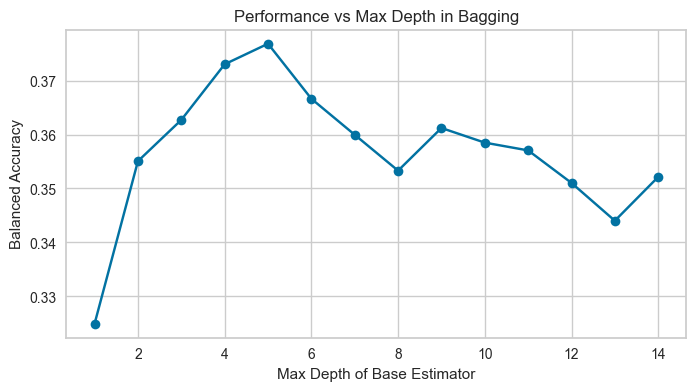

In [76]:
columns = ['total force rate_walk', 'pace_walk', 'step rate_walk', 'thomas tfl', 'genu valgo',
           'pronation excursion (mp->to)_walk', 'thomas psoas', 'impact gs_walk', 'tfi', 'contact ratio_walk',
           'stride length_walk', 'edad', 'index minus','arco aplanado', 'stance excursion (fs->mp)_walk']

# Configurar el RandomForestClassifier como el estimador base
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Configurar el BaggingClassifier utilizando el RandomForest como estimador
bagging_model = BaggingClassifier(
    estimator=rf_classifier,
    n_estimators=10,
    random_state=42
)

# Configuración para GridSearchCV
# Crear un GridSearchCV para optimizar max_depth del RandomForest
param_grid_bagging = {'estimator__max_depth': range(1, 15)}
grid_bagging = GridSearchCV(bagging_model, param_grid=param_grid_bagging, scoring='balanced_accuracy', cv=10, verbose=2)
grid_bagging.fit(X_train[columns], y_train)

# Imprimir los resultados
print("Best mean cross-validation score: {:.3f}".format(grid_bagging.best_score_))
print("Best parameters: {}".format(grid_bagging.best_params_))

# Extracción de resultados para visualización
scores = grid_bagging.cv_results_['mean_test_score']
max_depths = range(1, 15)

# Gráfica de los resultados
plt.figure(figsize=(8, 4))
plt.plot(max_depths, scores, '-o')
plt.xlabel('Max Depth of Base Estimator')
plt.ylabel('Balanced Accuracy')
plt.title('Performance vs Max Depth in Bagging')
plt.grid(True)
plt.show()

In [77]:
best_bagging_model = grid_bagging.best_estimator_

print("Test Accuracy: {:.3f}".format(best_bagging_model.score(X_test[columns], y_test)))
print("Train: ",best_bagging_model .score(X_train[columns],y_train))
print("Test: ",best_bagging_model .score(X_test[columns],y_test))

Test Accuracy: 0.451
Train:  0.743455497382199
Test:  0.4513888888888889


Predicciones realizadas con éxito
Conversión a numpy arrays exitosa
Cálculo de métricas exitoso
Resultados para BaggingClassifier:
Accuracy: 0.4514
Precision: 0.4502
Recall: 0.4526
F1 Score: 0.4499


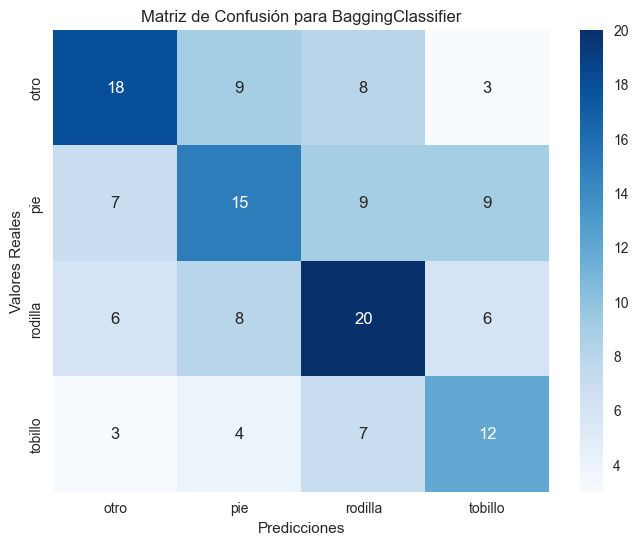

Visualización de la matriz de confusión exitosa


In [78]:
evaluate_model(best_bagging_model, X_test[columns], y_test)

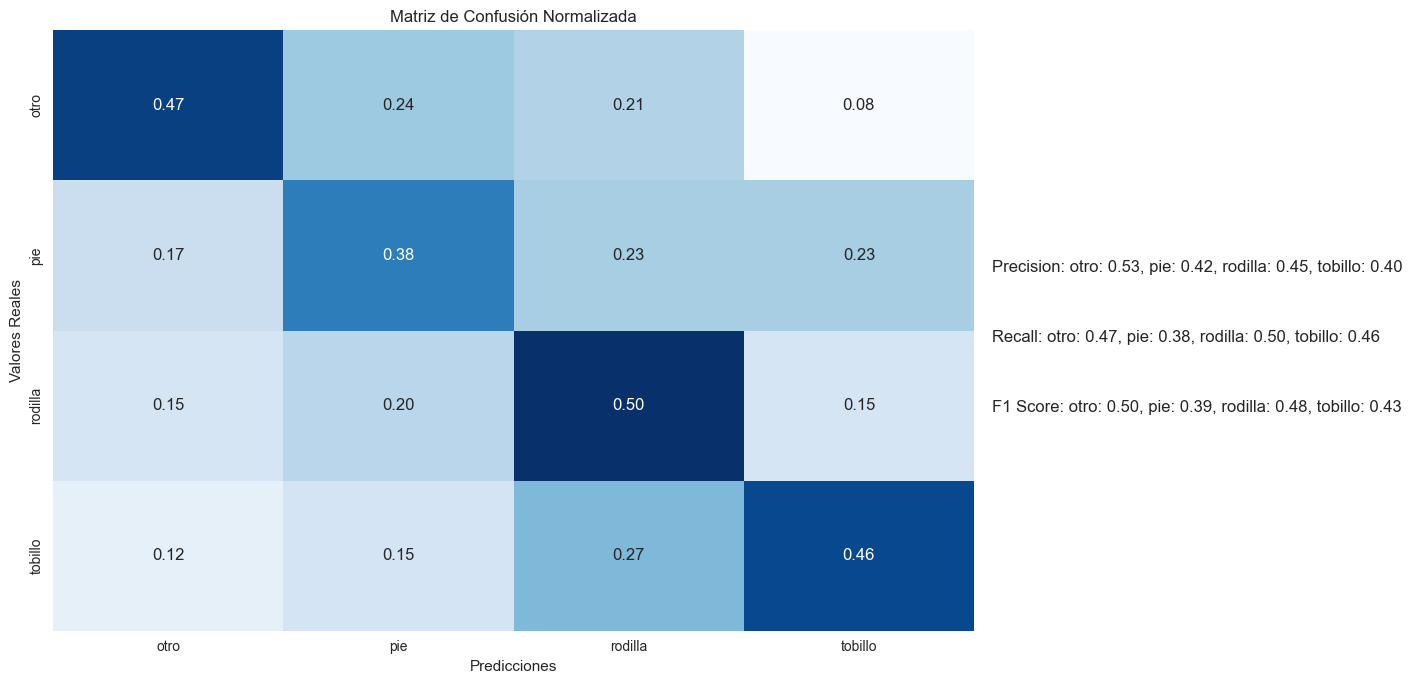


Classification Report:

              precision    recall  f1-score   support

        otro       0.53      0.47      0.50        38
         pie       0.42      0.38      0.39        40
     rodilla       0.45      0.50      0.48        40
     tobillo       0.40      0.46      0.43        26

    accuracy                           0.45       144
   macro avg       0.45      0.45      0.45       144
weighted avg       0.45      0.45      0.45       144



In [79]:
y_pred = best_bagging_model.predict(X_test[columns])  # Etiquetas predichas por el modeloModel
plot_confusion_matrix_with_metrics(y_test, y_pred)

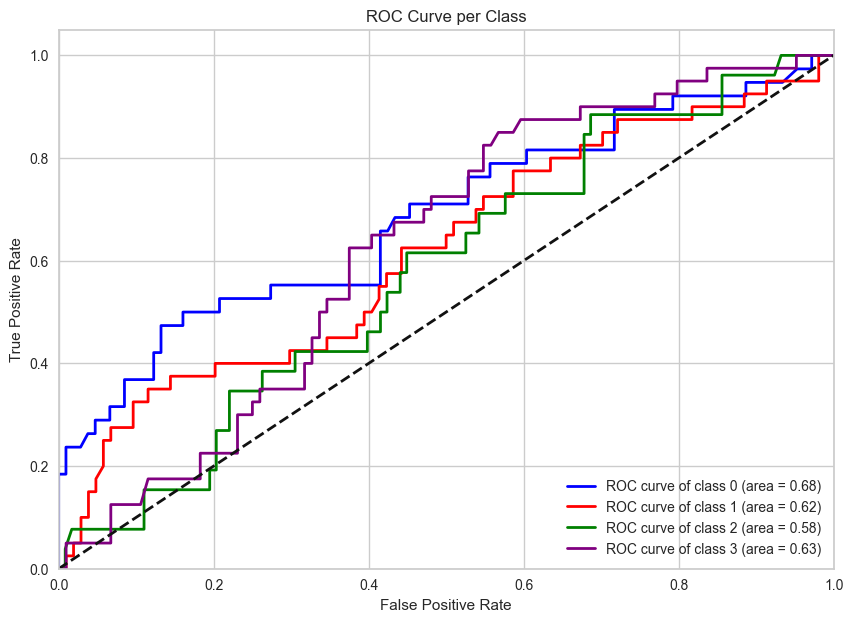

In [80]:
plot_multiclass_roc(best_bagging_model, X_test[columns], y_test)

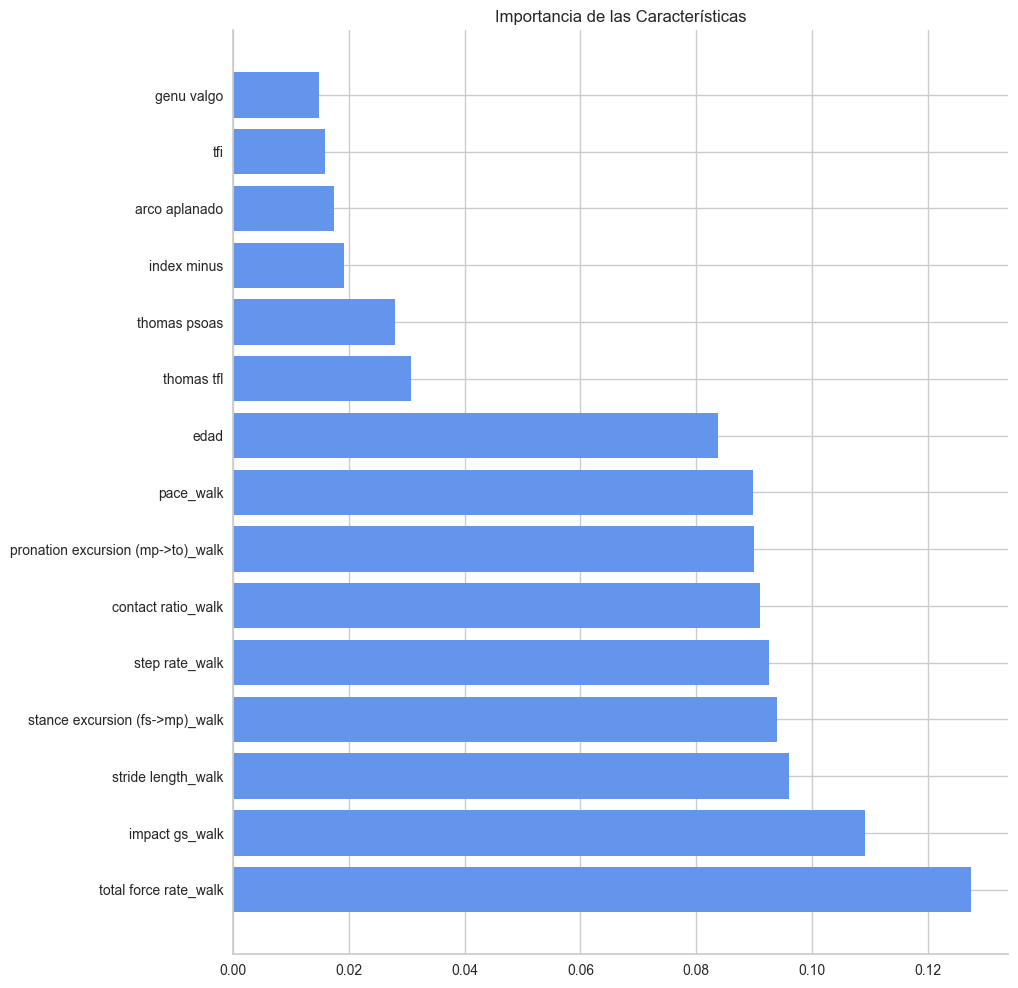

In [81]:
plot_feature_importances_bagging(best_bagging_model, columns)

## Gradient Boosting Classifier

In [82]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Configuración de la búsqueda en malla para GradientBoostingClassifier
param_grid_gbc = {
    #'n_estimators': [100, 200, 300],
    'n_estimators': [100, 200],
    'max_depth': range(3, 10),
    'learning_rate': [0.01, 0.1, 0.2]
}

# Crear el modelo de GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=42)
grid_gbc = GridSearchCV(estimator=gbc, param_grid=param_grid_gbc, cv=10, scoring='balanced_accuracy', verbose=2)
grid_gbc.fit(X_train[columns], y_train)

# Imprimir los mejores resultados de la validación cruzada
print("Best mean cross-validation score: {:.3f}".format(grid_gbc.best_score_))
print("Best parameters: {}".format(grid_gbc.best_params_))

Fitting 10 folds for each of 42 candidates, totalling 420 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.7s
[CV] END ..learning_rate=0.01, max_depth=3, n_

[CV] END ..learning_rate=0.01, max_depth=8, n_estimators=100; total time=   1.2s
[CV] END ..learning_rate=0.01, max_depth=8, n_estimators=100; total time=   1.2s
[CV] END ..learning_rate=0.01, max_depth=8, n_estimators=100; total time=   1.2s
[CV] END ..learning_rate=0.01, max_depth=8, n_estimators=100; total time=   1.2s
[CV] END ..learning_rate=0.01, max_depth=8, n_estimators=100; total time=   1.2s
[CV] END ..learning_rate=0.01, max_depth=8, n_estimators=100; total time=   1.2s
[CV] END ..learning_rate=0.01, max_depth=8, n_estimators=100; total time=   1.2s
[CV] END ..learning_rate=0.01, max_depth=8, n_estimators=100; total time=   1.2s
[CV] END ..learning_rate=0.01, max_depth=8, n_estimators=100; total time=   1.2s
[CV] END ..learning_rate=0.01, max_depth=8, n_estimators=200; total time=   2.3s
[CV] END ..learning_rate=0.01, max_depth=8, n_estimators=200; total time=   2.3s
[CV] END ..learning_rate=0.01, max_depth=8, n_estimators=200; total time=   2.4s
[CV] END ..learning_rate=0.0

[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=   0.8s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=   0.8s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=   0.8s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=   0.8s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=   0.8s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=   0.8s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=   0.8s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=200; total time=   1.5s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=200; total time=   1.6s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=200; total time=   1.5s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=200; total time=   1.6s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=200; total time=   1.6s
[CV] END ...learning_rate=0.

[CV] END ...learning_rate=0.2, max_depth=4, n_estimators=100; total time=   0.5s
[CV] END ...learning_rate=0.2, max_depth=4, n_estimators=100; total time=   0.5s
[CV] END ...learning_rate=0.2, max_depth=4, n_estimators=100; total time=   0.5s
[CV] END ...learning_rate=0.2, max_depth=4, n_estimators=100; total time=   0.5s
[CV] END ...learning_rate=0.2, max_depth=4, n_estimators=100; total time=   0.5s
[CV] END ...learning_rate=0.2, max_depth=4, n_estimators=200; total time=   0.9s
[CV] END ...learning_rate=0.2, max_depth=4, n_estimators=200; total time=   0.9s
[CV] END ...learning_rate=0.2, max_depth=4, n_estimators=200; total time=   0.9s
[CV] END ...learning_rate=0.2, max_depth=4, n_estimators=200; total time=   0.9s
[CV] END ...learning_rate=0.2, max_depth=4, n_estimators=200; total time=   0.9s
[CV] END ...learning_rate=0.2, max_depth=4, n_estimators=200; total time=   0.9s
[CV] END ...learning_rate=0.2, max_depth=4, n_estimators=200; total time=   0.9s
[CV] END ...learning_rate=0.

[CV] END ...learning_rate=0.2, max_depth=9, n_estimators=100; total time=   1.4s
[CV] END ...learning_rate=0.2, max_depth=9, n_estimators=100; total time=   1.3s
[CV] END ...learning_rate=0.2, max_depth=9, n_estimators=100; total time=   1.3s
[CV] END ...learning_rate=0.2, max_depth=9, n_estimators=200; total time=   2.3s
[CV] END ...learning_rate=0.2, max_depth=9, n_estimators=200; total time=   2.3s
[CV] END ...learning_rate=0.2, max_depth=9, n_estimators=200; total time=   2.3s
[CV] END ...learning_rate=0.2, max_depth=9, n_estimators=200; total time=   2.3s
[CV] END ...learning_rate=0.2, max_depth=9, n_estimators=200; total time=   2.3s
[CV] END ...learning_rate=0.2, max_depth=9, n_estimators=200; total time=   2.3s
[CV] END ...learning_rate=0.2, max_depth=9, n_estimators=200; total time=   2.3s
[CV] END ...learning_rate=0.2, max_depth=9, n_estimators=200; total time=   2.3s
[CV] END ...learning_rate=0.2, max_depth=9, n_estimators=200; total time=   2.2s
[CV] END ...learning_rate=0.

In [83]:
# Ajustar el modelo óptimo
best_gbc = GradientBoostingClassifier(random_state=42, max_depth=grid_gbc.best_params_['max_depth'],
                                      learning_rate=grid_gbc.best_params_['learning_rate'],
                                      n_estimators=grid_gbc.best_params_['n_estimators'])
gbc = best_gbc.fit(X_train[columns], y_train)

# Evaluación del modelo
print("Train accuracy: {:.3f}".format(best_gbc.score(X_train[columns], y_train)))
print("Test accuracy: {:.3f}".format(best_gbc.score(X_test[columns], y_test)))

Train accuracy: 0.918
Test accuracy: 0.319


Predicciones realizadas con éxito
Conversión a numpy arrays exitosa
Cálculo de métricas exitoso
Resultados para GradientBoostingClassifier:
Accuracy: 0.3194
Precision: 0.3124
Recall: 0.3093
F1 Score: 0.3082


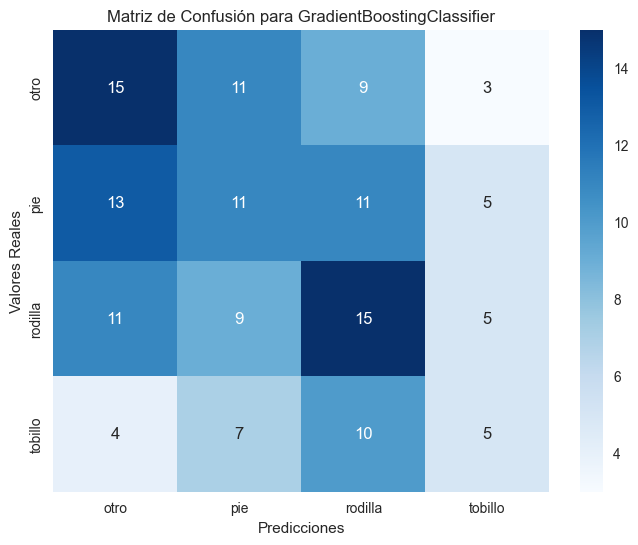

Visualización de la matriz de confusión exitosa


In [84]:
evaluate_model(gbc, X_test[columns], y_test)

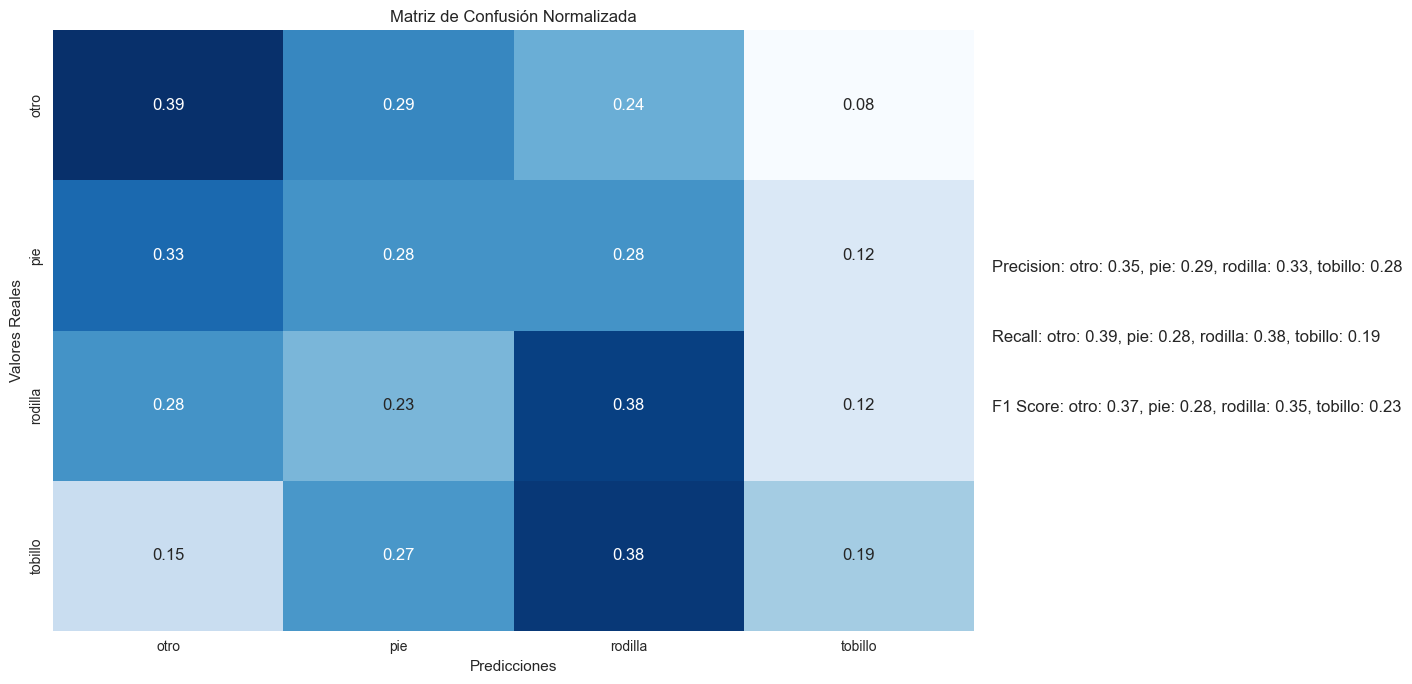


Classification Report:

              precision    recall  f1-score   support

        otro       0.35      0.39      0.37        38
         pie       0.29      0.28      0.28        40
     rodilla       0.33      0.38      0.35        40
     tobillo       0.28      0.19      0.23        26

    accuracy                           0.32       144
   macro avg       0.31      0.31      0.31       144
weighted avg       0.32      0.32      0.32       144



In [85]:
y_pred = gbc.predict(X_test[columns])  # Etiquetas predichas por el modeloModel
plot_confusion_matrix_with_metrics(y_test, y_pred)

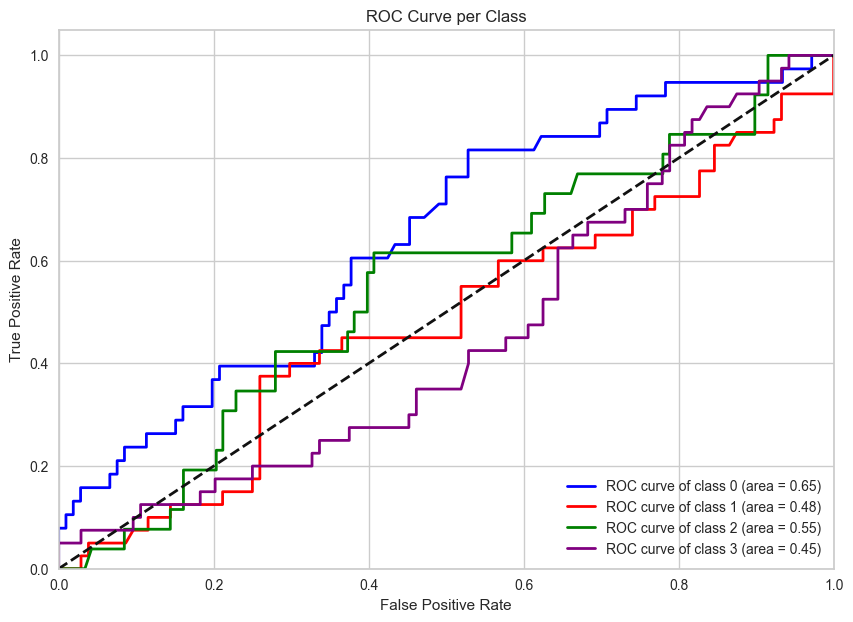

In [86]:
plot_multiclass_roc(gbc, X_test[columns], y_test)